## Overview: Analysis using lme4/lmerTest package 
### Preparation
1. Install packages and load libraries
1. Set working directory and import data
1. Replace 999/777 in income and education. Create puberty status variable. 
1. Specify data type (numeric/factor/ordinal)
1. Copy smri variables and change colnames before winsorization 
1. Standardize smri_vol variables
1. Winsorize smri vol variables

### Work in progress
1. Loop lmertest over dependent variables
1. How to deal with weights argument (solve error)

### Preparation

#### 1. Install packages and load libraries

In [3]:
#install packages 
if (!('lme4'     %in% installed.packages()[,"Package"])) install.packages('lme4')
if (!('psych'     %in% installed.packages()[,"Package"])) install.packages('psych')
if (!('EMAtools' %in% installed.packages()[,"Package"])) install.packages('EMAtools')  #lme.dscore
if (!('naniar'   %in% installed.packages()[,"Package"])) install.packages('naniar')    #replace values 
if (!('jtools'   %in% installed.packages()[,"Package"])) install.packages('jtools')
if (!('ggplot2'  %in% installed.packages()[,"Package"])) install.packages('ggplot2')
if (!('sjPlot'   %in% installed.packages()[,"Package"])) install.packages('sjPlot')
if (!('effects'  %in% installed.packages()[,"Package"])) install.packages('effects')
if (!('lmerTest' %in% installed.packages()[,"Package"])) install.packages('lmerTest')
if (!('tidyverse'   %in% installed.packages()[,"Package"])) install.packages('tidyverse') #organize data in long format (for heatmaps)
if (!('glmmTMB'   %in% installed.packages()[,"Package"])) install.packages('glmmTMB') #plot effects
if (!('viridis'   %in% installed.packages()[,"Package"])) install.packages('viridis') #colormap heatmaps

# load libraries
if(!"lme4" %in% .packages())     library(lme4)
if(!"psych" %in% .packages())     library(psych)
if(!"EMAtools" %in% .packages()) library(EMAtools)
if(!"naniar" %in% .packages())   library(naniar)
if(!"jtools" %in% .packages())   library(jtools)
if(!"ggplot2" %in% .packages())  library(ggplot2)
if(!"sjPlot" %in% .packages())   library(sjPlot)
if(!"effects" %in% .packages())  library(effects)
if(!"lmerTest" %in% .packages())  library(lmerTest)      # pvalues models
if(!"tidyverse" %in% .packages())   library(tidyverse)   # transform dataframe from wide to long format
if(!"glmmTMB" %in% .packages())   library(glmmTMB)       # plot effects
if(!"viridis" %in% .packages())   library(viridis)       # colormap heatmaps


also installing the dependencies ‘boot’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘tmvnsim’, ‘mnormt’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘estimability’, ‘mvtnorm’, ‘bayestestR’, ‘effectsize’, ‘emmeans’, ‘insight’, ‘parameters’, ‘performance’, ‘sjlabelled’, ‘sjmisc’, ‘DataCombine’, ‘lmerTest’, ‘sjstats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘gridExtra’, ‘visdat’, ‘viridis’, ‘UpSetR’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘pander’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘ggeffects’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also in

#### 2. Set working directory and import data

In [4]:
#set working directory to import PsychRisk3.tsv file that was created with the psychrisk_exploration.ipynb notebook
setwd("/shared/project-psychopathology-risk/outputs/exploration/")
df <- read.table(file = 'PsychRisk_data.tsv', sep = '\t', header = TRUE)

#### 3. Replace 999/777 in income and education, create puberty status variable and drop variables. 

In [5]:
# replace value 999 and 777 (don't know and refused to answer) to NA
df <- df %>%
  replace_with_na(replace = list(demo_comb_income_v2 = c(999, 777), 
                                 demo_prnt_ed_v2 = c(777)))

df$puberty <- ifelse(!is.na(df$pds_p_ss_female_category),df$pds_p_ss_female_category,df$pds_p_ss_male_category)
table(df$puberty, exclude=NULL)  #364 NAs

# drop variables that are not needed. Do not change because names1 will not be correct anymore. \n",
drop <- c("pds_p_ss_female_category", "pds_p_ss_male_category", "eventname", "mri_info_deviceserialnumber", "iqc_t1_ok_ser", "fsqc_qc", "mrif_score", "demo_prim")
df2 = df[,!(names(df) %in% drop)]


   1    2    3    4    5 <NA> 
5291 2408 2366  152    8  364 

#### 4. Specify data type (numeric/factor/ordinal)

In [6]:
names1 <- c(1,4,5, 7,8, 25:47, 187:193)  #column numbers categorical variables
df2[names1]<- lapply(df2[names1],factor)
df2$interview_date <- as.Date(df2$interview_date, "%m/%d/%Y")
df2$interview_age <- as.numeric(df2$interview_age)
df2$demo_comb_income_v2_order <- factor(df2$demo_comb_income_v2, order = TRUE)
df2$demo_prnt_ed_v2_order <- factor(df2$demo_prnt_ed_v2, order = TRUE)
df2$puberty <- factor(df2$puberty, order = TRUE)

#### 6. Create df with smri variables, change colnames and standardize smri variables

In [7]:
#create new df with smri variables and add win prefix to column names 
smri <- df2[grepl("^smri_vol", colnames(df2))] 
colnames(smri) <-paste("win",colnames(smri),sep="_") 

#standardization function
scale.many <- function(dat, column.nos) {
  nms <- names(dat)
  for(col in column.nos) {
    name <- paste(nms[col],".z", sep = "")
    dat[name] <- scale(dat[,col])
  }
  cat(paste("Scaled ", length(column.nos), " variable(s)\n"))
  dat
}

Scaled  155  variable(s)


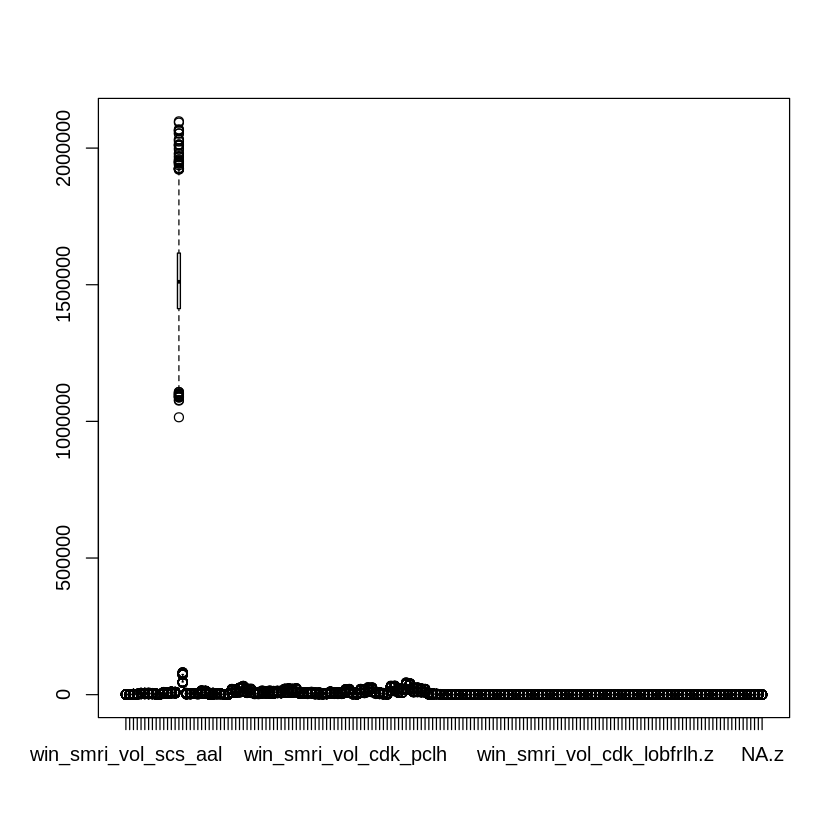

In [8]:
#standardize smri variables
smri_w <- scale.many(smri, c(1:155))

#keep standarized only
#smri_w <- smri_w[ -c(1:155) ] 
boxplot(smri_w)

In [27]:
#colnames(smri_w)

#### 7. Winsorize smri vol variables if 3sd above or below mean

Scaled  2  variable(s)


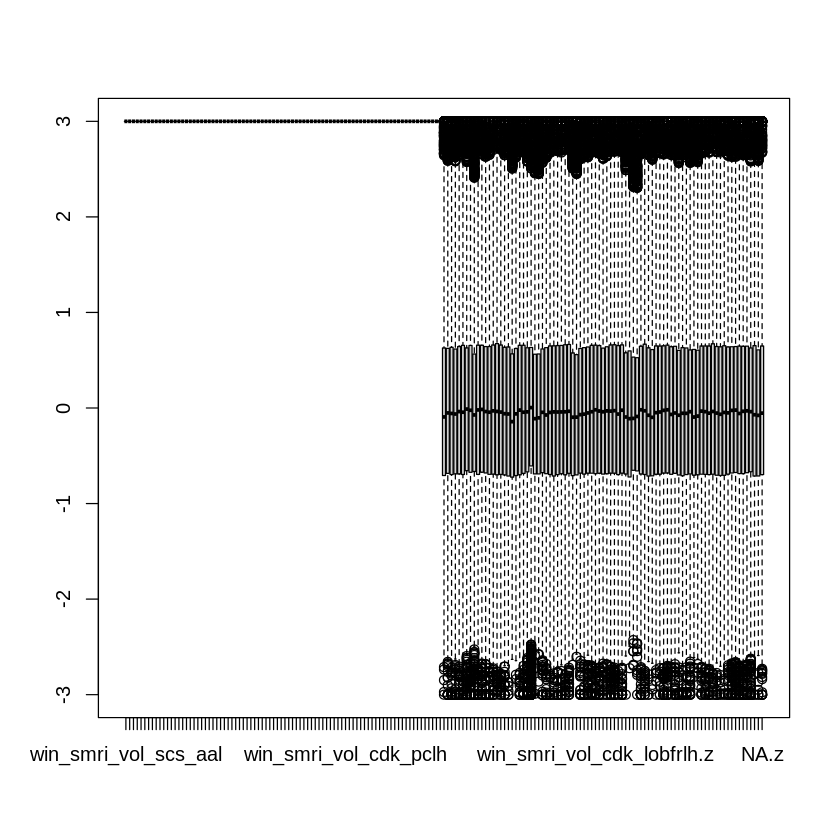

In [9]:
df3 <- smri_w
    
# Winsorization function
fun <- function(x){
    x[ x < -3 ] <- -3
    x[ x > 3 ] <- 3
    x
}

# Apply winsorization 
df3 <- fun(df3)
boxplot(df3) #check whether all values are within -3 and +3

# combine dataframes and standardize age
df4 <- cbind(df2, df3)
df4 <- scale.many(df4, c(3, 6)) #standardized age and acs_propensity

In [2]:
###Center Data###

df4$famhx_ss_momdad_dprs_p <- as.numeric(levels(df4$famhx_ss_momdad_dprs_p))[df4$famhx_ss_momdad_dprs_p]
df4$famhx_ss_momdad_dprs_p <- df4$famhx_ss_momdad_dprs_p - mean(df4$famhx_ss_momdad_dprs_p, na.rm=TRUE)

df4$famhx_ss_momdad_ma_p <- as.numeric(levels(df4$famhx_ss_momdad_ma_p))[df4$famhx_ss_momdad_ma_p]
df4$famhx_ss_momdad_ma_p <- df4$famhx_ss_momdad_ma_p - mean(df4$famhx_ss_momdad_ma_p, na.rm=TRUE)

df4$famhx_ss_momdad_nrv_p <- as.numeric(levels(df4$famhx_ss_momdad_nrv_p))[df4$famhx_ss_momdad_nrv_p]
df4$famhx_ss_momdad_nrv_p <- df4$famhx_ss_momdad_nrv_p - mean(df4$famhx_ss_momdad_nrv_p, na.rm=TRUE)

df4$famhx_ss_momdad_addiction <- as.numeric(levels(df4$famhx_ss_momdad_addiction))[df4$famhx_ss_momdad_addiction]
df4$famhx_ss_momdad_addiction <- df4$famhx_ss_momdad_addiction - mean(df4$famhx_ss_momdad_addiction)

df4$sex <- as.numeric(levels(df4$sex))[df4$sex]
df4$sex <- df4$sex - mean(df4$sex)

ERROR: Error in levels(df4$famhx_ss_momdad_dprs_p): object 'df4' not found


In [11]:
df4

subjectkey,interview_date,interview_age,sex,rel_family_id,acs_raked_propensity_score,race_ethnicity,site_id_l,smri_vol_scs_aal,smri_vol_scs_aar,⋯,win_smri_vol_cdk_suplrh.z,win_smri_vol_cdk_sutmlh.z,win_smri_vol_cdk_sutmrh.z,win_smri_vol_cdk_tmpolelh.z,win_smri_vol_cdk_tmpolerh.z,win_smri_vol_cdk_trvtmlh.z,win_smri_vol_cdk_trvtmrh.z,NA.z,interview_age.z,acs_raked_propensity_score.z
<fct>,<date>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
NDAR_INV00LJVZK2,2017-08-19,121,M,8315,616.1476,5,site11,525.1,580.4,⋯,-0.1412621,0.03431194,0.25828028,-0.3708050,0.08011196,-0.45545829,0.28661639,-0.2765674,0.2581958,-0.20103304
NDAR_INV01NAYMZH,2017-08-09,129,M,862,425.6335,1,site16,535.0,646.0,⋯,1.1964000,0.23907169,-0.40238092,0.8365820,1.23306373,1.75682730,-0.53870644,-0.8479142,1.3259696,-0.75329507
NDAR_INV01Z8HAPV,2017-11-19,122,F,11328,321.6282,1,site02,521.5,579.0,⋯,-0.5484348,0.12793204,-0.22406889,0.5860425,0.34791249,-0.21331758,-0.20764474,0.3679328,0.3916675,-1.05478551
NDAR_INV02RCED7D,2017-05-09,122,M,8783,428.3225,1,site06,483.7,622.4,⋯,-0.4781252,-0.57339750,0.05216365,-0.5893607,-0.92907321,-0.26468076,-0.54803213,-0.3309635,0.3916675,-0.74550019
NDAR_INV030X9ZNH,2018-06-11,126,F,8316,958.7208,1,site11,535.3,557.1,⋯,0.1902609,0.52321692,-0.56920845,-0.3548131,-0.02982721,1.50368020,0.90211139,-0.2660634,0.9255544,0.79201795
NDAR_INV03CV8RDT,2017-08-16,128,M,9763,429.6733,1,site09,450.8,507.4,⋯,-0.2427215,-0.43159863,-0.67075565,0.1595924,-0.04674093,-0.84801975,-0.24961031,0.3698085,1.1924979,-0.74158426
NDAR_INV042UJKFB,2017-01-17,128,F,3211,615.2732,1,site14,444.3,583.2,⋯,-0.9146676,1.05756324,-0.02037006,0.7006510,0.27180076,0.53511735,0.10476560,-0.9488284,1.1924979,-0.20356756
NDAR_INV04TRXUGL,2018-01-20,120,F,8785,527.0903,3,site06,555.0,477.7,⋯,-0.9044327,-1.43295050,-1.69106315,-1.5915186,-0.90370263,-1.23324361,-0.26826167,-1.6646062,0.1247240,-0.45919212
NDAR_INV06DJHEV0,2018-06-03,122,M,11331,311.2063,1,site02,600.2,689.3,⋯,1.0593408,-0.46280533,-0.33891393,1.6601639,0.80458288,0.16089988,0.58037537,-0.3947383,0.3916675,-1.08499635


### 1. LME loop over multiple dependent variables
1. Subcortical volumes
1. Cortical volumes
1. Cortical thickness


#### Steps
1. LME loop over multiple outcome variables
1. Create tables with p-values (uncorrected and corrected), t-values, cohen's d
1. Create heatmaps
1. Plot results 

In [13]:
#Add simplified pathology variable names to df4 for plots later
df4$Depression <- df4$famhx_ss_momdad_dprs_p
df4$Mania <- df4$famhx_ss_momdad_ma_p
df4$Addiction <- df4$famhx_ss_momdad_addiction 
df4$Nervousness <- df4$famhx_ss_momdad_nrv_p                      
#df4$Addiction <- factor(df4$Addiction, labels = c("Addiction = no", "Addiction = yes"))
#df4$Depression <- factor(df4$Depression, labels = c("no", "yes"))
#df4$Nervousness <- factor(df4$Nervousness, labels = c("no", "yes"))
#df4$Mania <- factor(df4$Mania, labels = c("Mania = no", "Mania = yes"))

#Variable for any pathology
df4$Pathology <- ifelse((df4$Depression == "1") | (df4$Mania == "1") | (df4$Addiction == "1") | 
(df4$Nervousness == "1"), 1, 0)

In [ ]:
## Subcortical volume
# Define variables
dependentVar = colnames(df4)[grepl("^win_smri_vol_scs.*.z$", colnames(df4)) & !grepl("smri_vol_scs_intracranialv", colnames(df4))]

#Removed Addiction, Mania, Nervousness# famhx_ss_momdad_dprs_p
independentVar <- c("win_smri_vol_scs_intracranialv.z", "interview_age.z", "sex", "race_ethnicity", 
                    "puberty", "demo_prnt_ed_v2","demo_comb_income_v2", 
                    "famhx_ss_momdad_dprs_p",
                   "(1|site_id_l/rel_family_id)")


no.dependentVar = length(dependentVar)
m <- as.list(1:no.dependentVar)
d <- as.list(1:no.dependentVar)
ptab <- data.frame(matrix(NA, nrow = 42, ncol = 7))
names(m) <- dependentVar
names(d) <- dependentVar
string_form <- paste0(dependentVar, "~", paste0(independentVar, collapse = " + "))

#for loop
    for (i in 1:no.dependentVar) {
        #print progress
        print(paste("Running lmer for dependent variable:", dependentVar[i], "which is", i, "out of", no.dependentVar))
        #store models in m
        m[[i]] <- lmer(string_form[i], data=df4, na.action = "na.omit")
        #cohen's d
        d[[i]] <- lme.dscore(m[[i]],data=df4,type="lme4") #Cohen's d
        ptab[[i]] <- as.data.frame(summary(m[[i]])$coefficients)
        #create dataframe (ptab)  with coefficient estimates, df, T, p-values and add sig column to indicate significance
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.1] <- "."
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.05] <- "*"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.01] <- "**"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.001] <- "***"
        ptab[[i]]$`Pr(>|t|)` <- round(ptab[[i]]$`Pr(>|t|)`,3) #3decimals
        ptab[[i]]$d[2:42] <- d[[i]]$d
        ptab[[i]]$d[2:42] = round(ptab[[i]]$d[2:42], 3)  #3 decimals
        ptab[[i]]$d[1] <- "NA"         #intercept

}    

In [20]:
# Preparation for the heatmaps - visualization of the results
# Extract the Cohen's d, p-values and T-values from ptab into seperate tables 
tabd <- data.frame(matrix(NA, nrow = 1, ncol = length(dependentVar)))  #14 is the number of pathologies (main + interactions)
tabp <- data.frame(matrix(NA, nrow = 1, ncol = length(dependentVar)))
tabt <- data.frame(matrix(NA, nrow = 1, ncol = length(dependentVar)))

for (i in 1:no.dependentVar)
    
{
tabd[[i]] <- as.numeric(ptab[[i]]$d[42])
tabp[[i]] <- as.numeric(ptab[[i]]$'Pr(>|t|)'[42])
tabt[[i]] <- as.numeric(ptab[[i]]$'t value'[42])
}

colnames(tabd) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabp) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabt) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabd) <- sub(".z", "", colnames(tabd))
colnames(tabp) <- sub(".z", "", colnames(tabp))
colnames(tabt) <- sub(".z", "", colnames(tabt))

# Create table with p-values corrected for multiple comparisons using Benjamini & Hochberg (1995) ("BH") correction
tabpcor <- sapply(tabp,p.adjust,method="BH")


In [16]:
# transform tables from wide to long format for heatmaps
#p-corrected
tabpcor_long <- as.data.frame(tabpcor) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabpcor_long$colname = factor(tabpcor_long$colname, levels=sort(unique(tabpcor_long$colname), decreasing=TRUE))

#p-uncorrected
tabp_long <- as.data.frame(tabp) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabp_long$colname = factor(tabp_long$colname, levels=sort(unique(tabp_long$colname), decreasing=TRUE))

#cohen's d
tabd_long <- as.data.frame(tabd) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabd_long$colname = factor(tabd_long$colname, levels=sort(unique(tabd_long$colname), decreasing=TRUE))

#T-values
tabt_long <- as.data.frame(tabt) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabt_long$colname = factor(tabt_long$colname, levels=sort(unique(tabt_long$colname), decreasing=TRUE))

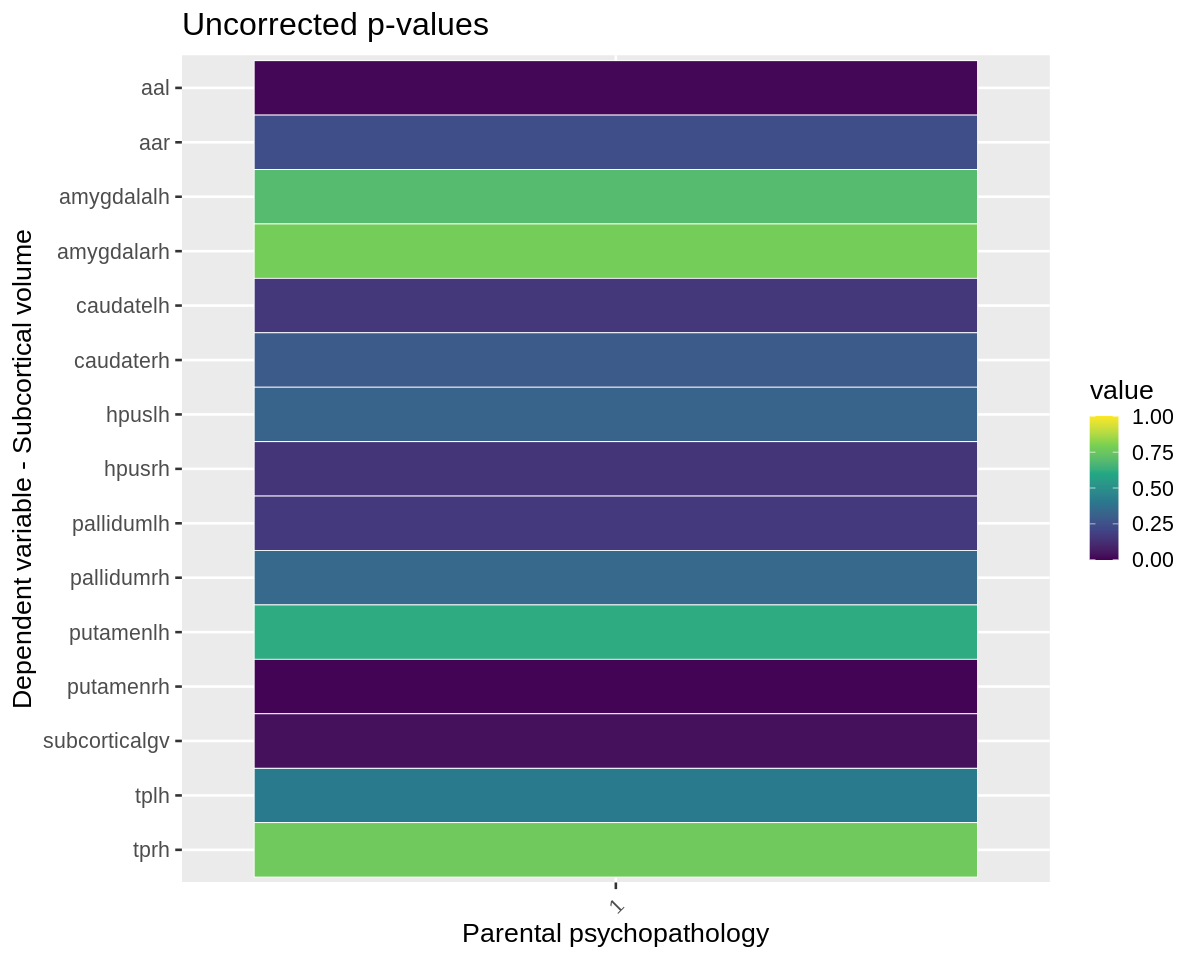

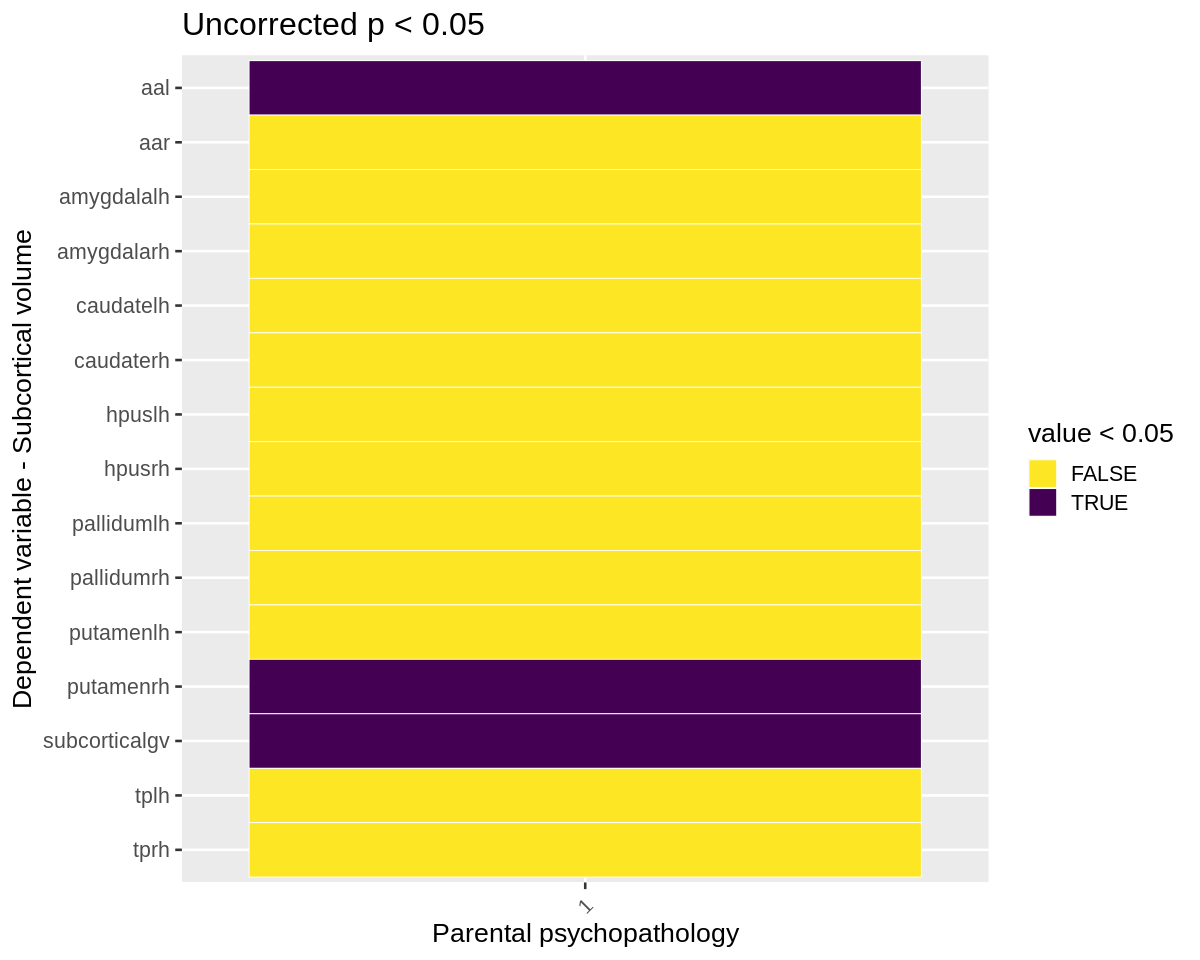

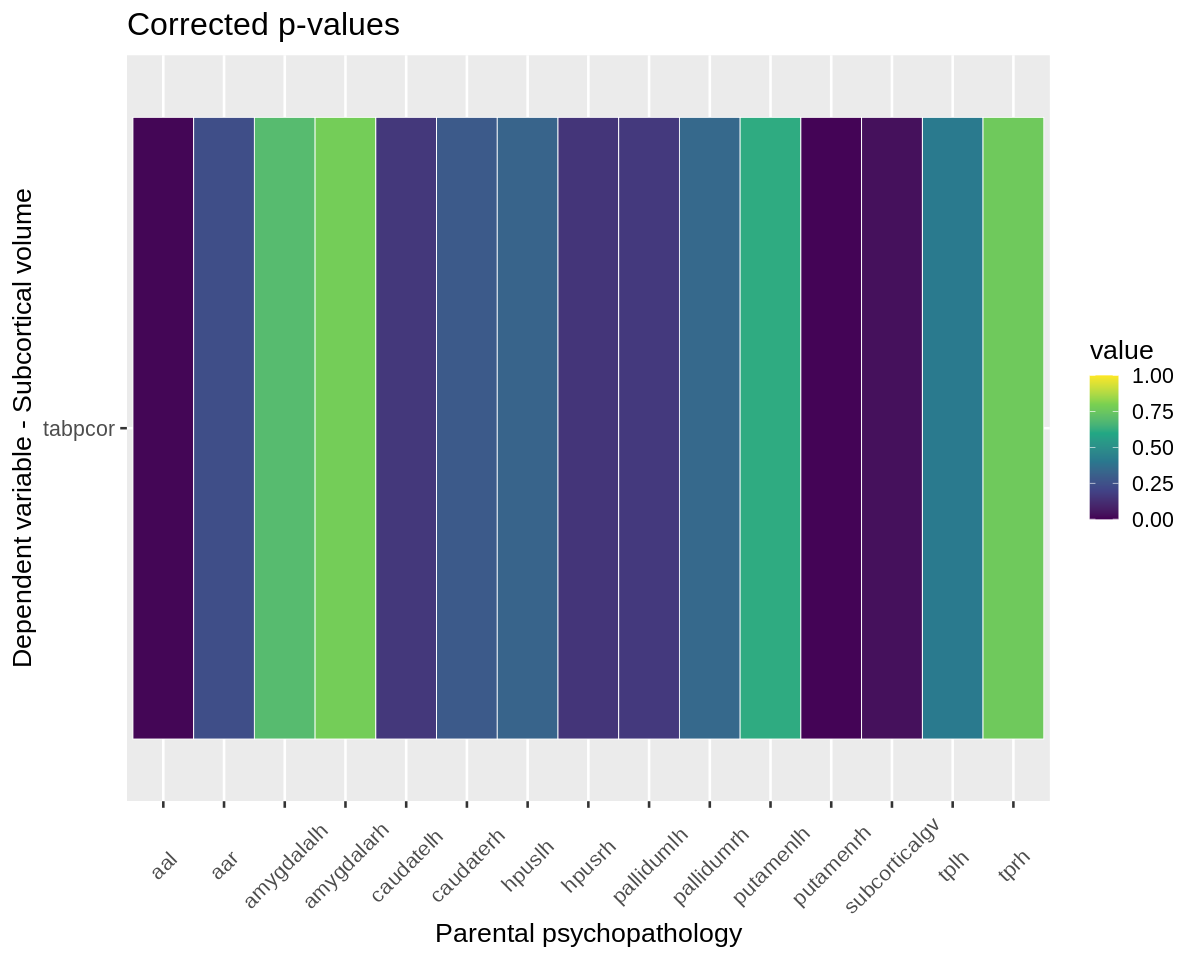

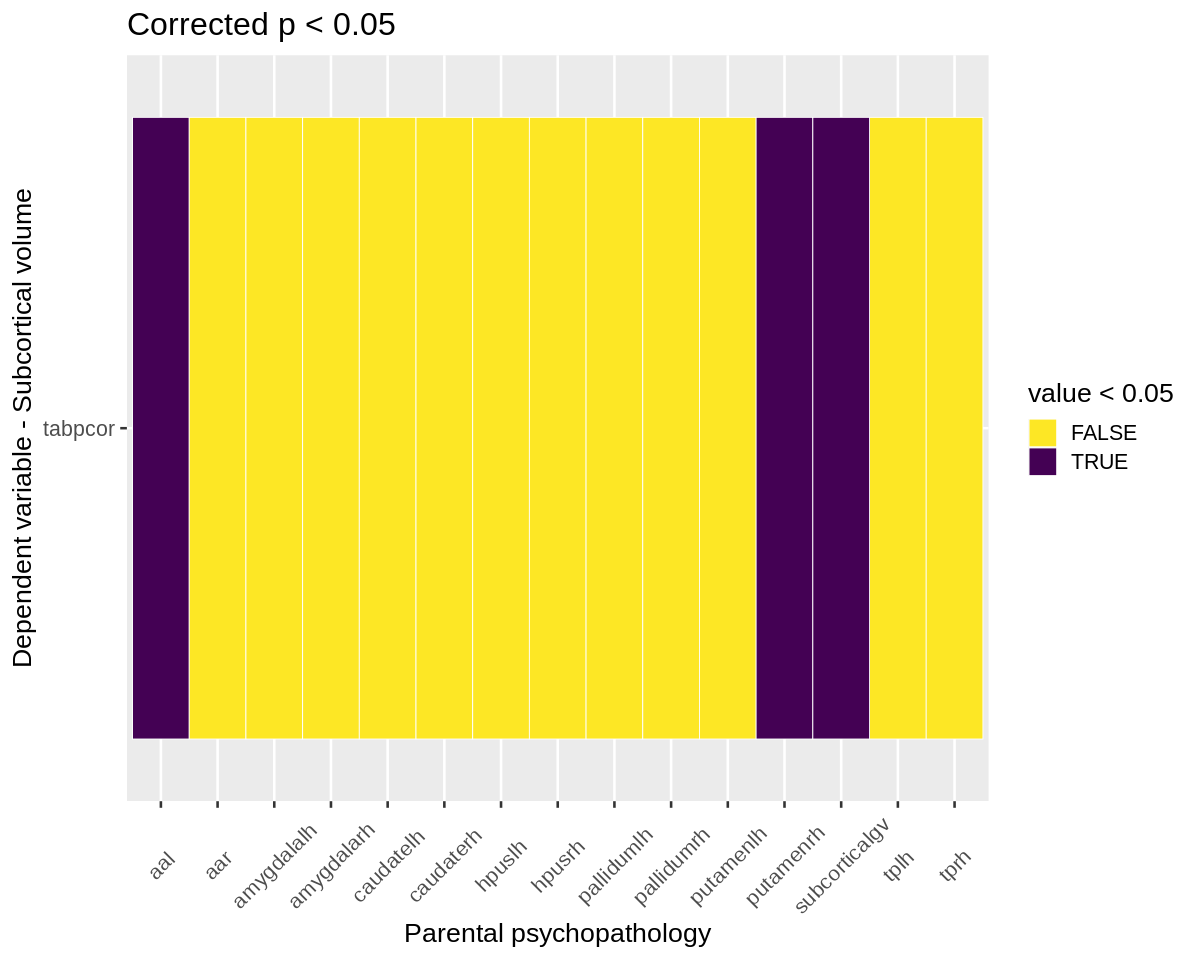

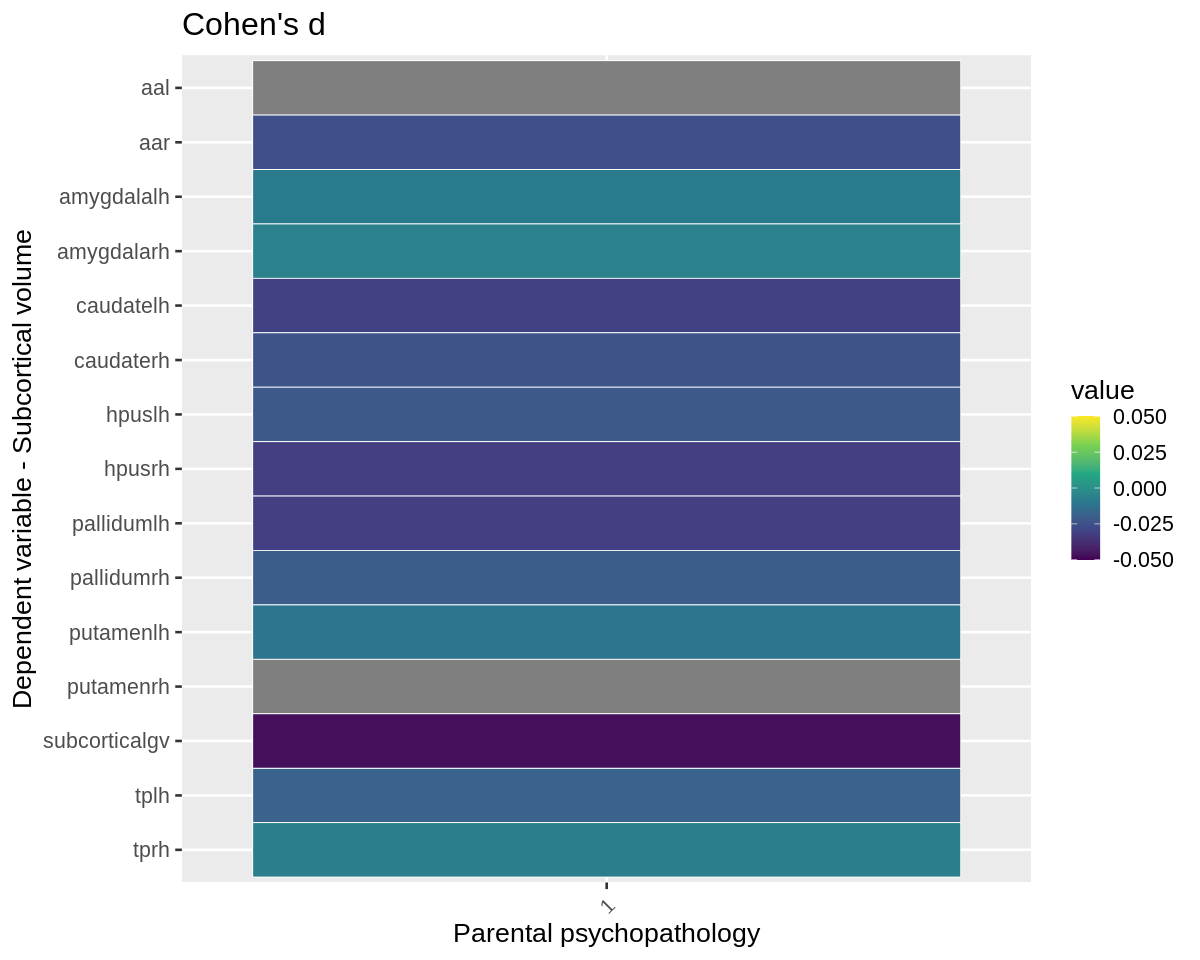

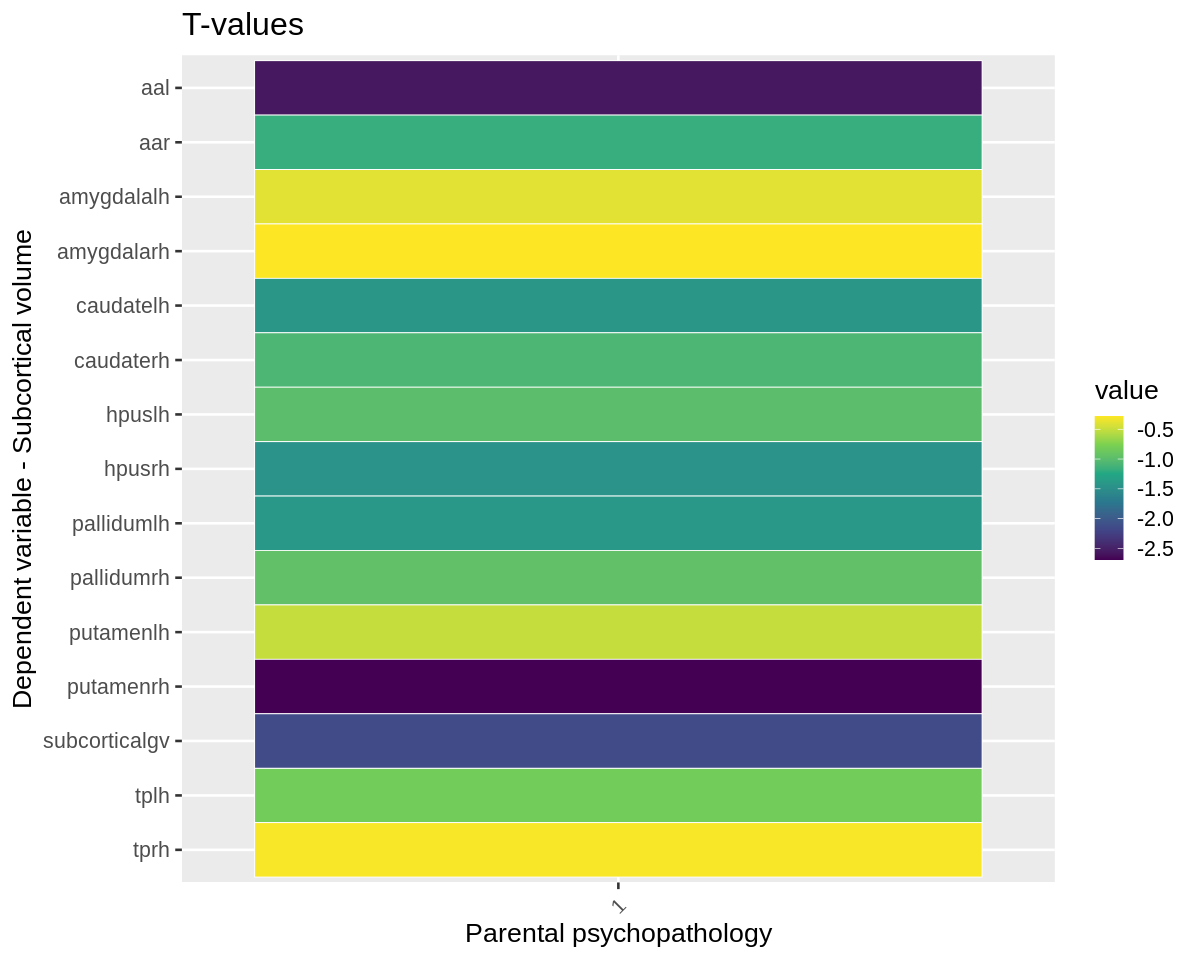

In [22]:
#Heatmaps
#Uncorrected P
options(repr.plot.width=10, repr.plot.height=8)
p1a <- ggplot(tabp_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25)+
  scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Uncorrected p-values") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p1a)

# logicals p < .05 - ONLY interesting if P-values were inserted in code above. 
p2a <- ggplot(tabp_long, aes(x = rowname, y = colname, fill = value < .05)) +
  geom_tile(colour="white",size=0.25) +
  scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Uncorrected p < 0.05") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) 
plot(p2a)

#Corrected P
p1b <- ggplot(tabpcor_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25) +
  scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Corrected p-values") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p1b)


# logicals p < .05 - ONLY interesting if P-values were inserted in code above. 
p2b <- ggplot(tabpcor_long, aes(x = rowname, y = colname, fill = value < .05)) +
  geom_tile(colour="white",size=0.25) +
  scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Corrected p < 0.05") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) 
plot(p2b)


#heatmap cohen's d
p3 <- ggplot(tabd_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25)+
  scale_fill_viridis_c(limits = c(-0.05,0.05))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Cohen's d")+
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p3)

p4 <- ggplot(tabt_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25)+
scale_fill_viridis_c() +
  labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "T-values")+
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p4)


In [16]:
m1a <- lmer(data=df4, win_smri_vol_scs_aal.z~ win_smri_vol_scs_intracranialv.z + interview_age.z + sex + race_ethnicity 
            +  puberty + demo_prnt_ed_v2_order + demo_comb_income_v2_order + 
            famhx_ss_momdad_dprs_p +
             (1|site_id_l/rel_family_id), na.action = "na.omit") 

In [97]:
#Interactions
m1a <- lmer(data=df4, win_smri_vol_scs_subcorticalgv.z~ win_smri_vol_scs_intracranialv.z + interview_age.z + sex + race_ethnicity 
            +  puberty + demo_prnt_ed_v2_order + demo_comb_income_v2_order + 
            famhx_ss_momdad_dprs_p * famhx_ss_momdad_ma_p * famhx_ss_momdad_addiction * famhx_ss_momdad_nrv_p +
             (1|site_id_l/rel_family_id), na.action = "na.omit") 

In [95]:
#No Interactions
m1a <- lmer(data=df4, win_smri_vol_scs_subcorticalgv.z~ win_smri_vol_scs_intracranialv.z + interview_age.z + sex + race_ethnicity 
            +  puberty + demo_prnt_ed_v2_order + demo_comb_income_v2_order + 
            famhx_ss_momdad_dprs_p + famhx_ss_momdad_ma_p + famhx_ss_momdad_addiction + famhx_ss_momdad_nrv_p +
             (1|site_id_l/rel_family_id), na.action = "na.omit") 

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00743412 (tol = 0.002, component 1)”


In [98]:
summ(m1a)

MODEL INFO:
Observations: 8775
Dependent Variable: win_smri_vol_scs_subcorticalgv.z
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 13900.55, BIC = 14318.25
Pseudo-R² (fixed effects) = 0.71
Pseudo-R² (total) = 0.88 

FIXED EFFECTS:
---------------------------------------------------------------------------------------------------------
                                                                                                     Est.
------------------------------------------------------------------------------------------------- -------
(Intercept)                                                                                         -0.09
win_smri_vol_scs_intracranialv.z                                                                     0.86
interview_age.z                                                                                     -0.00
sexM                                                                                                 0.09
race_ethnicity2  

In [ ]:
# Further examine results of left caudate (m[[5]]), right caudate (m[[6]]), and right thalamus (m[[14]])
summ(m[[14]])

In [24]:
#Change names for plots
df4$Depression <- df4$famhx_ss_momdad_dprs_p
df4$Mania <- df4$famhx_ss_momdad_ma_p
df4$Addiction <- df4$famhx_ss_momdad_addiction 
df4$Nervousness <- df4$famhx_ss_momdad_nrv_p                      
df4$Addiction <- factor(df4$Addiction, labels = c("Addiction = no", "Addiction = yes"))
df4$Depression <- factor(df4$Depression, labels = c("no", "yes"))
df4$Nervousness <- factor(df4$Nervousness, labels = c("no", "yes"))
df4$Mania <- factor(df4$Mania, labels = c("Mania = no", "Mania = yes"))
df4$Caudate.Left.z <- df4$win_smri_vol_scs_caudatelh.z
df4$Caudate.Right.z <- df4$win_smri_vol_scs_caudaterh.z 
df4$Thalamus.Right.z <- df4$win_smri_vol_scs_tprh.z

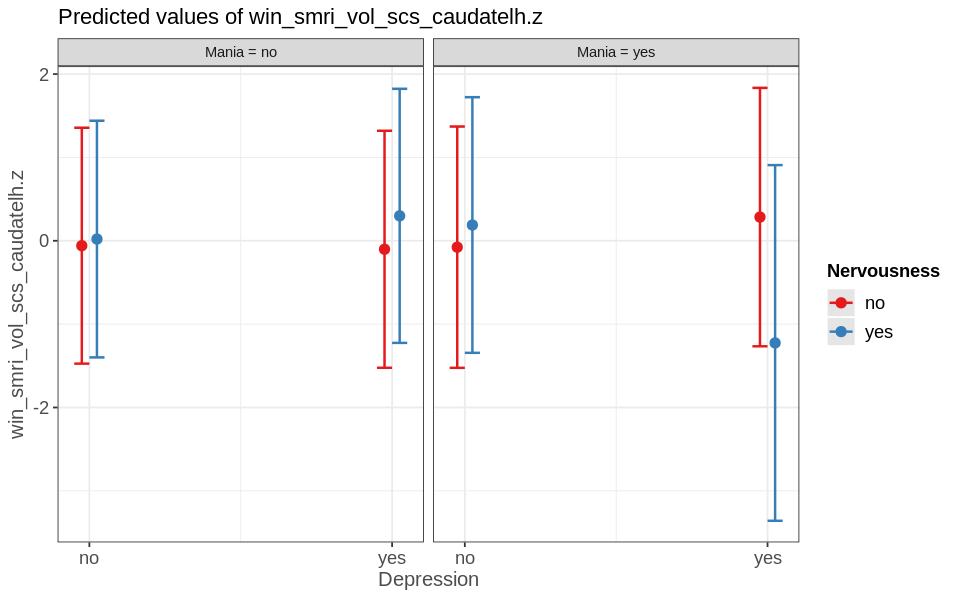

In [71]:
# plot effects
set_theme(
    base = theme_bw(),
)

# Three-way interaction in left and right caudate
#left caudate
p1_pred <- plot_model(m[[5]], type="pred", terms = c("Depression", "Nervousness", "Mania")) #plot interaction
#p1_re <- plot_model(m[[5]], type="re", terms = c("famhx_ss_momdad_dprs_p", "famhx_ss_momdad_ma_p", "famhx_ss_momdad_nrv_p")) #random effects
#p1_diag <- plot_model(m[[5]], "diag") #assumptions
p1_pred
#p1_re
#p1_diag

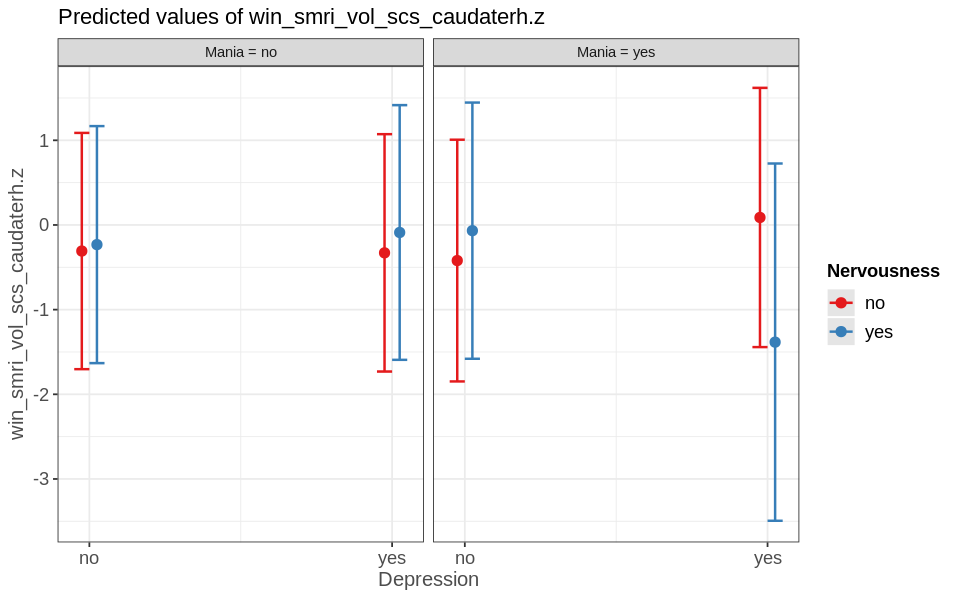

In [72]:
#right caudate
p2_pred <- plot_model(m[[6]], type="pred", terms = c("Depression", "Nervousness", "Mania")) #plot interaction
#p2_re <- plot_model(m[[6]], type="re", terms = c("famhx_ss_momdad_dprs_p", "famhx_ss_momdad_ma_p", "famhx_ss_momdad_nrv_p")) #random effects
#p2_diag <- plot_model(m[[7]], "diag") #assumptions
p2_pred
#p2_re
#p2_diag

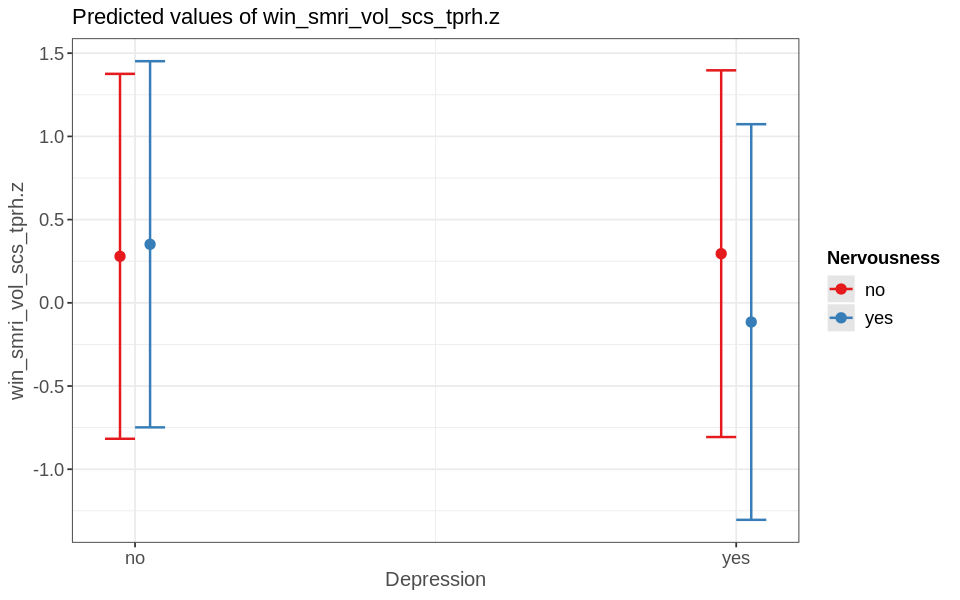

In [74]:
#right thalamus
p3_pred <- plot_model(m[[14]], type="pred", terms = c("Depression", "Nervousness")) #plot interaction
#p3_re <- plot_model(m[[14]], type="re", terms = c("famhx_ss_momdad_dprs_p", "famhx_ss_momdad_nrv_p")) #random effects
#p3_diag <- plot_model(m[[14]], "diag") #assumptions
p3_pred
#p3_re
#p3_diag

#### Interpretation: 
The results of the linear mixed models that examined the effect of parental psychopathology on subcortical brain volume in 8775 children showed two three-way interactions and one two-way interaction. The three-way interactions between depression, mania, and nervousness were observed in the left (Estimate = -2.10, SE = 0.37, p = 0.03) and right caudate (Estimate = -1.99, SE = 0.98, p = 0.04). Plots revealed that children of parents that endorsed all three types of pathology showed lower bilateral caudate volume than children of parents that endorsed none, one or two pathology types. Further, a two-way interaction between depression and nervousness was observed in the right thalamus (Estimate = -0.48, SE = 0.24, p < 0.05). Children of parents with depression and nervousness comorbidity showed lower right thalamus volume than children of parents with none or one of these two types of pathology. However, none of the findings did survive the correction for multiple comparisons (Benjamini & Hochberg, 1995). Therefore, we conclude that parental psychopathology was not associated with differences in subcortical brain volume. 

### Cortical volume

Two models did not reach convergence, including win_smri_vol_cdk_lingualrh.z (right lingual gyrus) and win_smri_vol_cdk_ihcaterh.z (right isthmus cingulate). Several strategies were applied to resolve this problem: 
1. Try different algorithms 
2. Increase the number of iterations
3. Restart the model from the parameter estimates reached before the algorithm failed

Unfortunately, none of these worked. Therefore, a simpler model was examined for these two variables by removing one of the random effects (either site or family). 

https://www.rdocumentation.org/packages/lme4/versions/1.1-26/topics/lmerControl

https://biologyforfun.wordpress.com/2018/04/09/help-i-have-convergence-warnings/


In [ ]:
# Define variables. Exclude right lingual and right isthmus cingulate, because of convergence problems
dependentVar <- colnames(df4)[grepl("^win_smri_vol_cdk.*.z$", colnames(df4)) & !grepl("lingualrh", colnames(df4)) & !grepl("ihcaterh", colnames(df4)) ]
 
independentVar <- c("win_smri_vol_scs_intracranialv.z", "interview_age.z", "sex", "race_ethnicity", 
                    "puberty", "demo_prnt_ed_v2","demo_comb_income_v2", 
                    "famhx_ss_momdad_dprs_p*famhx_ss_momdad_addiction*famhx_ss_momdad_ma_p*famhx_ss_momdad_nrv_p",
                    "(1|site_id_l/rel_family_id)")


no.dependentVar = length(dependentVar)
m <- as.list(1:no.dependentVar)
d <- as.list(1:no.dependentVar)
ptab <- data.frame(matrix(NA, nrow = 56, ncol = 7))
names(m) <- dependentVar
names(d) <- dependentVar
string_form <- paste0(dependentVar, "~", paste0(independentVar, collapse = " + "))

#for loop
    for (i in 1:no.dependentVar) {
        #print progress
        print(paste("Running lmer for dependent variable:", dependentVar[i], "which is", i, "out of", no.dependentVar))
        #store models in m
        m[[i]] <- lmer(string_form[i], data=df4, na.action = "na.omit")
             
        #cohen's d
        d[[i]] <- lme.dscore(m[[i]],data=df4,type="lme4") #Cohen's d
        ptab[[i]] <- as.data.frame(summary(m[[i]])$coefficients)
        #create dataframe (ptab)  with coefficient estimates, df, T, p-values and add sig column to indicate significance
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.1] <- "."
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.05] <- "*"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.01] <- "**"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.001] <- "***"
        ptab[[i]]$`Pr(>|t|)` <- round(ptab[[i]]$`Pr(>|t|)`,3) #3decimals
        ptab[[i]]$d[2:56] <- d[[i]]$d
        ptab[[i]]$d[2:56] = round(ptab[[i]]$d[2:56], 3)  #3 decimals
        ptab[[i]]$d[1] <- "NA"                           #intercept
}  

In [ ]:
# SKIP IF INTERESTED IN 66 REGIONS
#Simpler model for the right lingual and right isthmus cingulate, because of previous convergence problems

dependentVar <- c("win_smri_vol_cdk_lingualrh.z", "win_smri_vol_cdk_ihcaterh.z")

independentVar <- c("win_smri_vol_scs_intracranialv.z", "interview_age.z", "sex", "race_ethnicity", 
                    "puberty", "demo_prnt_ed_v2","demo_comb_income_v2", 
                    "famhx_ss_momdad_dprs_p*famhx_ss_momdad_addiction*famhx_ss_momdad_ma_p*famhx_ss_momdad_nrv_p",
                     "(1|rel_family_id)")


no.dependentVar = length(dependentVar)
m <- as.list(1:no.dependentVar)
d <- as.list(1:no.dependentVar)
ptab <- data.frame(matrix(NA, nrow = 56, ncol = 7))
names(m) <- dependentVar
names(d) <- dependentVar
string_form <- paste0(dependentVar, "~", paste0(independentVar, collapse = " + "))

#for loop
    for (i in 1:no.dependentVar) {
        #print progress
        print(paste("Running lmer for dependent variable:", dependentVar[i], "which is", i, "out of", no.dependentVar))
        #store models in m
        m[[i]] <- lmer(string_form[i], data=df4, na.action = "na.omit")
             
        #cohen's d
        d[[i]] <- lme.dscore(m[[i]],data=df4,type="lme4") #Cohen's d
        ptab[[i]] <- as.data.frame(summary(m[[i]])$coefficients)
        #create dataframe (ptab)  with coefficient estimates, df, T, p-values and add sig column to indicate significance
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.1] <- "."
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.05] <- "*"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.01] <- "**"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.001] <- "***"
        ptab[[i]]$`Pr(>|t|)` <- round(ptab[[i]]$`Pr(>|t|)`,3) #3decimals
        ptab[[i]]$d[2:56] <- d[[i]]$d
        ptab[[i]]$d[2:56] = round(ptab[[i]]$d[2:56], 3)  #3 decimals
        ptab[[i]]$d[1] <- "NA"         #intercept

}  

In [ ]:
tabd2 <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))  #15 is the number of pathologies (main + interactions)
tabp2 <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))
tabt2 <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))

for (i in 1:no.dependentVar)
    
{
tabd2[[i]] <- as.numeric(ptab[[i]]$d[42:56])
tabp2[[i]] <- as.numeric(ptab[[i]]$'Pr(>|t|)'[42:56])
tabt2[[i]] <- as.numeric(ptab[[i]]$'t value'[42:56])
}

colnames(tabd2) <- sub("^win_smri_vol_cdk_", "", dependentVar)
colnames(tabp2) <- sub("^win_smri_vol_cdk_", "", dependentVar)
colnames(tabt2) <- sub("^win_smri_vol_cdk_", "", dependentVar)
colnames(tabd2) <- sub(".z", "", colnames(tabd2))
colnames(tabp2) <- sub(".z", "", colnames(tabp2))
colnames(tabt2) <- sub(".z", "", colnames(tabt2))


rownames(tabd2) <- c('D', 'A', 'M', 'N', 'DA', 'DM', 'AM', 'DN', 'AN', 'MN', 'DAM', 'DAN', 'DMN', 'AMN', 'DAMN'))
rownames(tabp2) <- c('D', 'A', 'M', 'N', 'DA', 'DM', 'AM', 'DN', 'AN', 'MN', 'DAM', 'DAN', 'DMN', 'AMN', 'DAMN'))
rownames(tabt2) <- c('D', 'A', 'M', 'N', 'DA', 'DM', 'AM', 'DN', 'AN', 'MN', 'DAM', 'DAN', 'DMN', 'AMN', 'DAMN'))

# Create table with p-values corrected for multiple comparisons using Benjamini & Hochberg (1995) ("BH") correction
tabp2cor <- sapply(tabp2,p.adjust,method="BH")
rownames(tabp2cor) <- c('D', 'A', 'M', 'N', 'DA', 'DM', 'AM', 'DN', 'AN', 'MN', 'DAM', 'DAN', 'DMN', 'AMN', 'DAMN'))

In [ ]:
# transform tables from wide to long format for heatmaps
#p-corrected
tabp2cor_long <- as.data.frame(tabp2cor) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabp2cor_long$colname = factor(tabp2cor_long$colname, levels=sort(unique(tabp2cor_long$colname), decreasing=TRUE))

#p-uncorrected
tabp2_long <- as.data.frame(tabp2) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabp2_long$colname = factor(tabp2_long$colname, levels=sort(unique(tabp2_long$colname), decreasing=TRUE))

#cohen's d
tabd2_long <- as.data.frame(tabd2) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabd2_long$colname = factor(tabd2_long$colname, levels=sort(unique(tabd2_long$colname), decreasing=TRUE))

#T-values
tabt2_long <- as.data.frame(tabt2) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabt2_long$colname = factor(tabt2_long$colname, levels=sort(unique(tabt2_long$colname), decreasing=TRUE))


In [ ]:
#Heatmaps
#Uncorrected P
p1a <- ggplot(tabp2_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile() + 
  scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Uncorrected p-values")
plot(p1a)

# logicals p < .05 - ONLY interesting if P-values were inserted in code above. 
p2a <- ggplot(tabp2_long, aes(x = rowname, y = colname, fill = value < .05)) +
  geom_tile() +
  scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Uncorrected p < 0.05")
plot(p2a)

#Corrected P
p1b <- ggplot(tabp2cor_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile() + 
  scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Corrected p-values")
plot(p1b)

# logicals p < .05 - ONLY interesting if P-values were inserted in code above. 
p2b <- ggplot(tabp2cor_long, aes(x = rowname, y = colname, fill = value < .05)) +
  geom_tile() +
  scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Corrected p < 0.05")
plot(p2b)


#heatmap cohen's d
p3 <- ggplot(tabd2_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile() +
scale_fill_viridis_c() +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Cohen's d")
plot(p3)

p4 <- ggplot(tabt2_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile() +
scale_fill_viridis_c() +
  labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "T-values")
plot(p4)

### Cortical thickness

In [ ]:
#[1] "Running lmer for dependent variable: win_smri_thick_cdk_parsopclh.z which is 39 out of 68"
#[1] "Running lmer for dependent variable: win_smri_thick_cdk_insularh.z which is 22 out of 68"


In [ ]:
# Define variables - all thickness except for mean, left pars opercularis and right insula 
dependentVar <- colnames(df4)[grepl("^win_smri_thick.*.z$", colnames(df4)) & !grepl("mean", colnames(df4)) & 
                              !grepl("win_smri_thick_cdk_insularh.z", colnames(df4)) & !grepl("win_smri_thick_cdk_parsopclh.z", colnames(df4))]

independentVar <- c("win_smri_vol_scs_intracranialv.z", "interview_age.z", "sex", "race_ethnicity", 
                    "puberty", "demo_prnt_ed_v2","demo_comb_income_v2", 
                    "Depression*Addiction*Mania*Nervousness",
                    "(1|site_id_l/rel_family_id)")
 
no.dependentVar = length(dependentVar)  
m <- as.list(1:no.dependentVar)         
d <- as.list(1:no.dependentVar)         
ptab <- data.frame(matrix(NA, nrow = 56, ncol = 7))  
names(m) <- dependentVar
names(d) <- dependentVar
string_form <- paste0(dependentVar, "~", paste0(independentVar, collapse = " + "))

#for loop
    for (i in 1:no.dependentVar) {
        #print progress
        print(paste("Running lmer for dependent variable:", dependentVar[i], "which is", i, "out of", no.dependentVar))
        #store models in m
        m[[i]] <- lmer(string_form[i], data=df4, na.action = "na.omit", control = lmerControl(optimizer="bobyqa"))
        #cohen's d
        d[[i]] <- lme.dscore(m[[i]],data=df4,type="lme4") #Cohen's d
        ptab[[i]] <- as.data.frame(summary(m[[i]])$coefficients)
        #create dataframe (ptab)  with coefficient estimates, df, T, p-values and add sig column to indicate significance
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.1] <- "."
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.05] <- "*"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.01] <- "**"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.001] <- "***"
        ptab[[i]]$`Pr(>|t|)` <- round(ptab[[i]]$`Pr(>|t|)`,3) #3decimals
        ptab[[i]]$d[2:56] <- d[[i]]$d
        ptab[[i]]$d[2:56] = round(ptab[[i]]$d[2:56], 3)  #3 decimals
        ptab[[i]]$d[1] <- "NA"         #intercept

}    

In [79]:
tabd3 <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))  #15 is the number of pathologies (main + interactions)
tabp3 <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))
tabt3 <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))

for (i in 1:no.dependentVar)
    
{
tabd3[[i]] <- as.numeric(ptab[[i]]$d[42:56])
tabp3[[i]] <- as.numeric(ptab[[i]]$'Pr(>|t|)'[42:56])
tabt3[[i]] <- as.numeric(ptab[[i]]$'t value'[42:56])
}

colnames(tabd3) <- sub("^win_smri_thick_cdk_", "", dependentVar) #remove prefix of variable names
colnames(tabp3) <- sub("^win_smri_thick_cdk_", "", dependentVar)
colnames(tabt3) <- sub("^win_smri_thick_cdk_", "", dependentVar)
colnames(tabd3) <- sub(".z", "", colnames(tabd3))                #remove suffix of variable names
colnames(tabp3) <- sub(".z", "", colnames(tabp3))
colnames(tabt3) <- sub(".z", "", colnames(tabt3))

# Rename rows
rownames(tabd3) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')
rownames(tabp3) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')
rownames(tabt3) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')

# Create table with p-values corrected for multiple comparisons using Benjamini & Hochberg (1995) ("BH") correction
tabp3cor <- sapply(tabp3,p.adjust,method="BH")
rownames(tabp3cor) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')

In [80]:
# transform tables from wide to long format for heatmaps
#p-corrected
tabp3cor_long <- as.data.frame(tabp3cor) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabp3cor_long$colname = factor(tabp3cor_long$colname, levels=sort(unique(tabp3cor_long$colname), decreasing=TRUE))

#p-uncorrected
tabp3_long <- as.data.frame(tabp3) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabp3_long$colname = factor(tabp3_long$colname, levels=sort(unique(tabp3_long$colname), decreasing=TRUE))

#cohen's d
tabd3_long <- as.data.frame(tabd3) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabd3_long$colname = factor(tabd3_long$colname, levels=sort(unique(tabd3_long$colname), decreasing=TRUE))

#T-values
tabt3_long <- as.data.frame(tabt3) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabt3_long$colname = factor(tabt3_long$colname, levels=sort(unique(tabt3_long$colname), decreasing=TRUE))

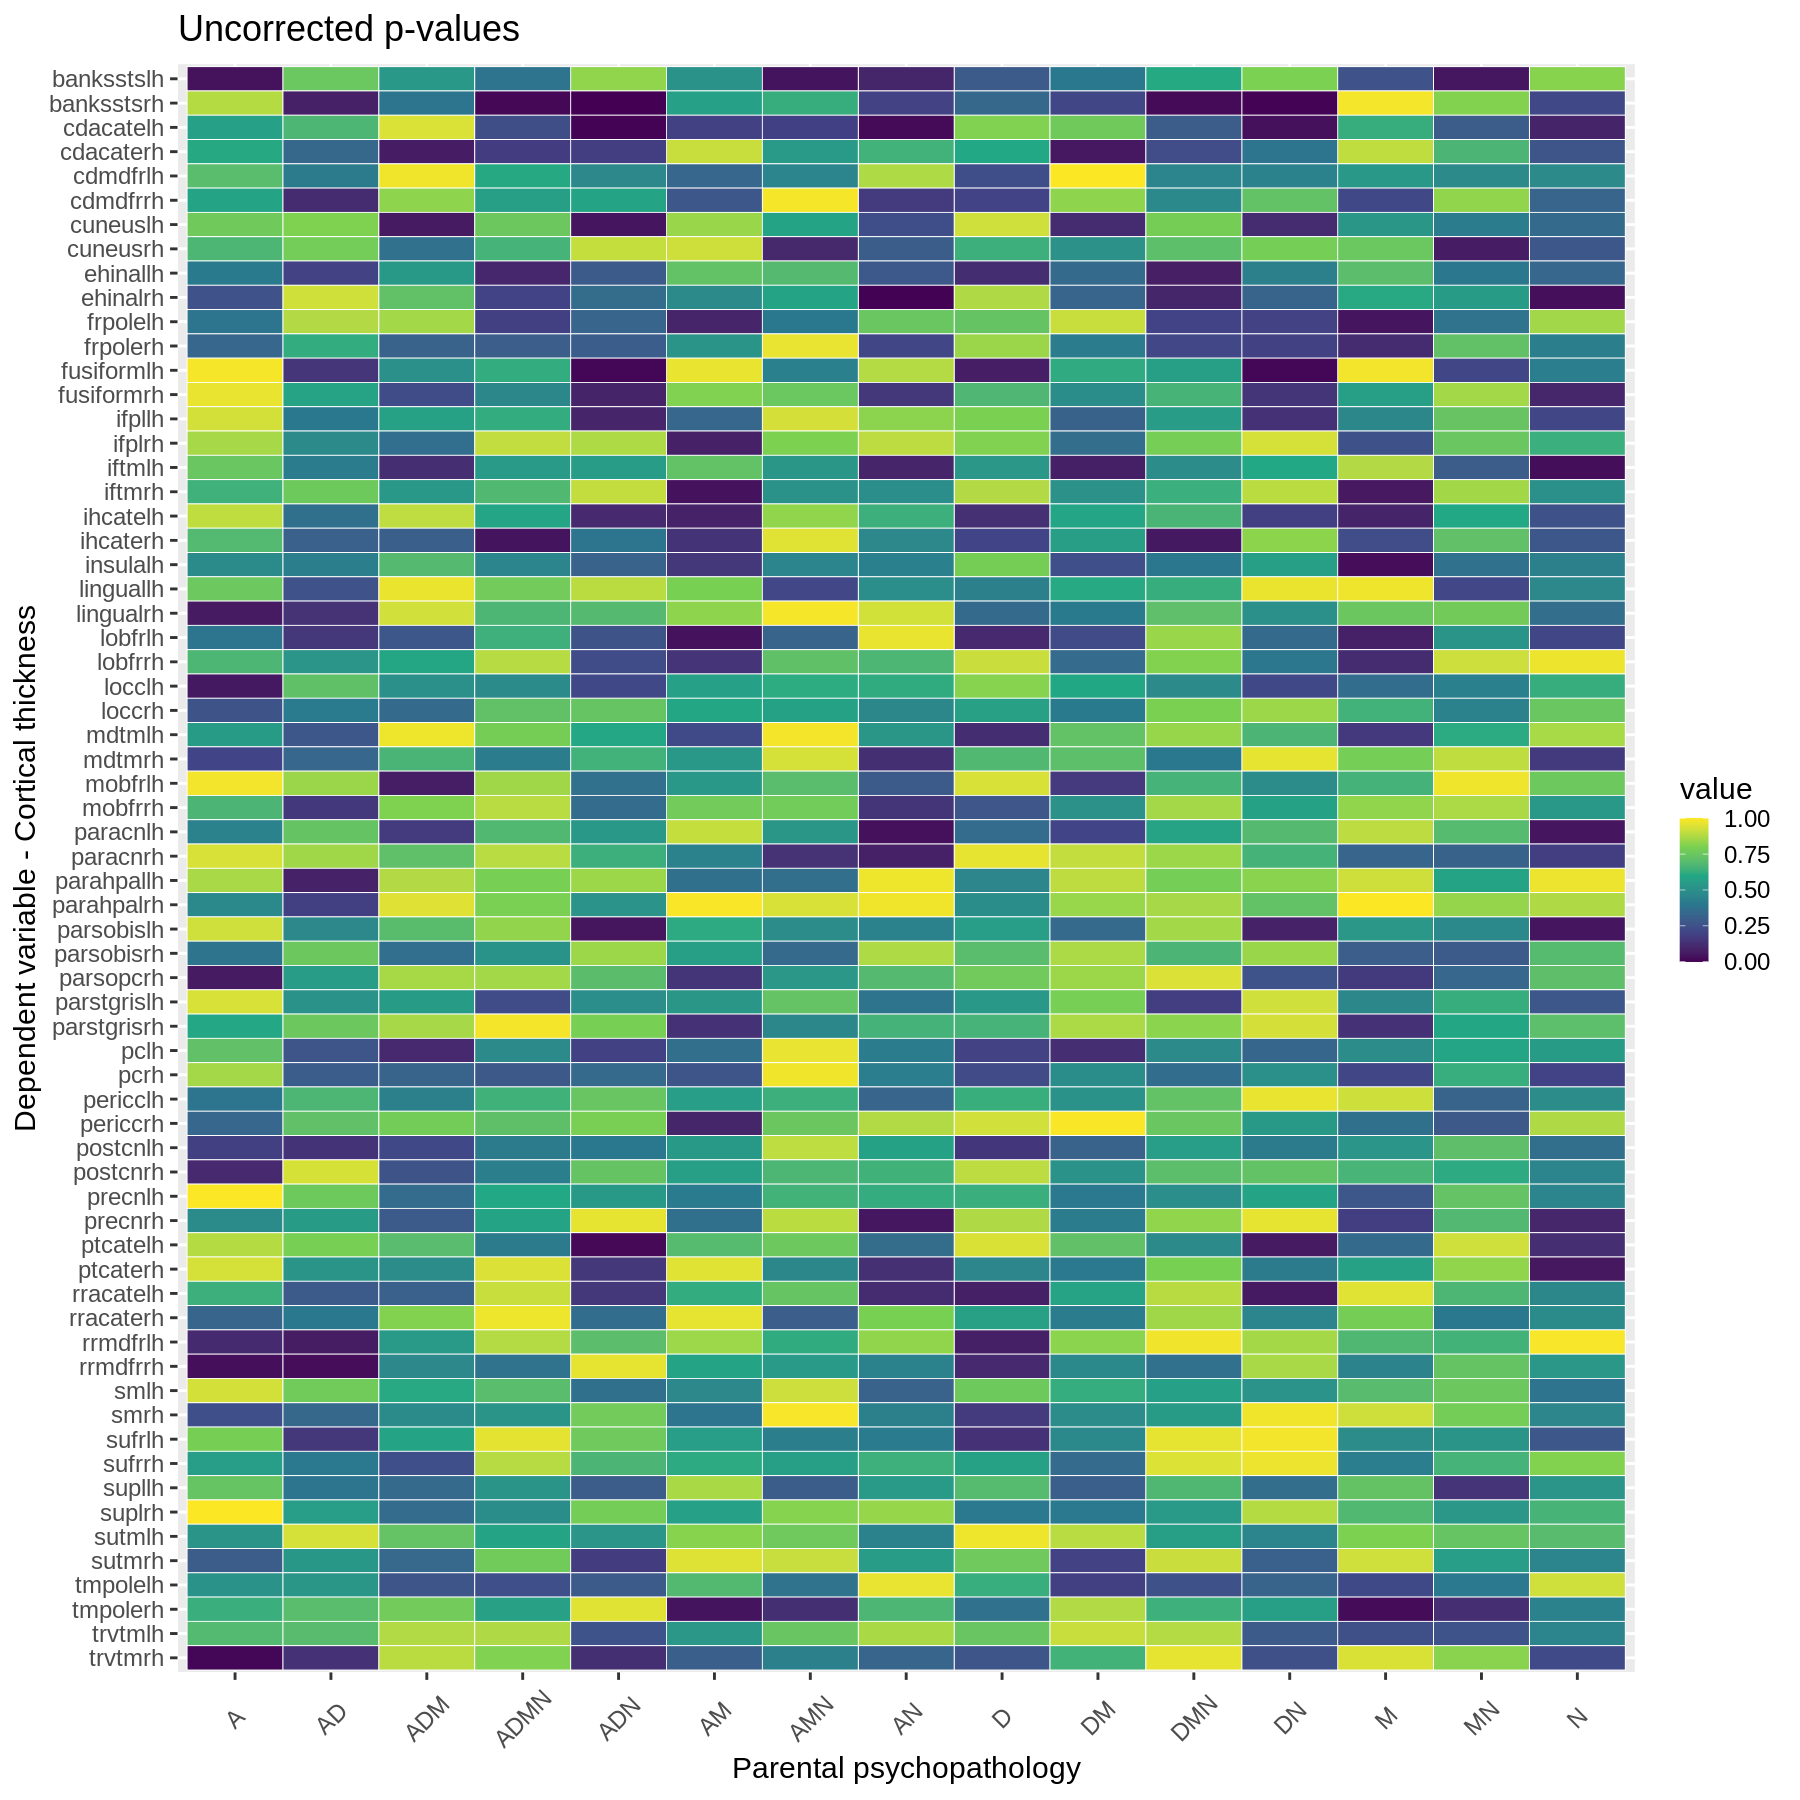

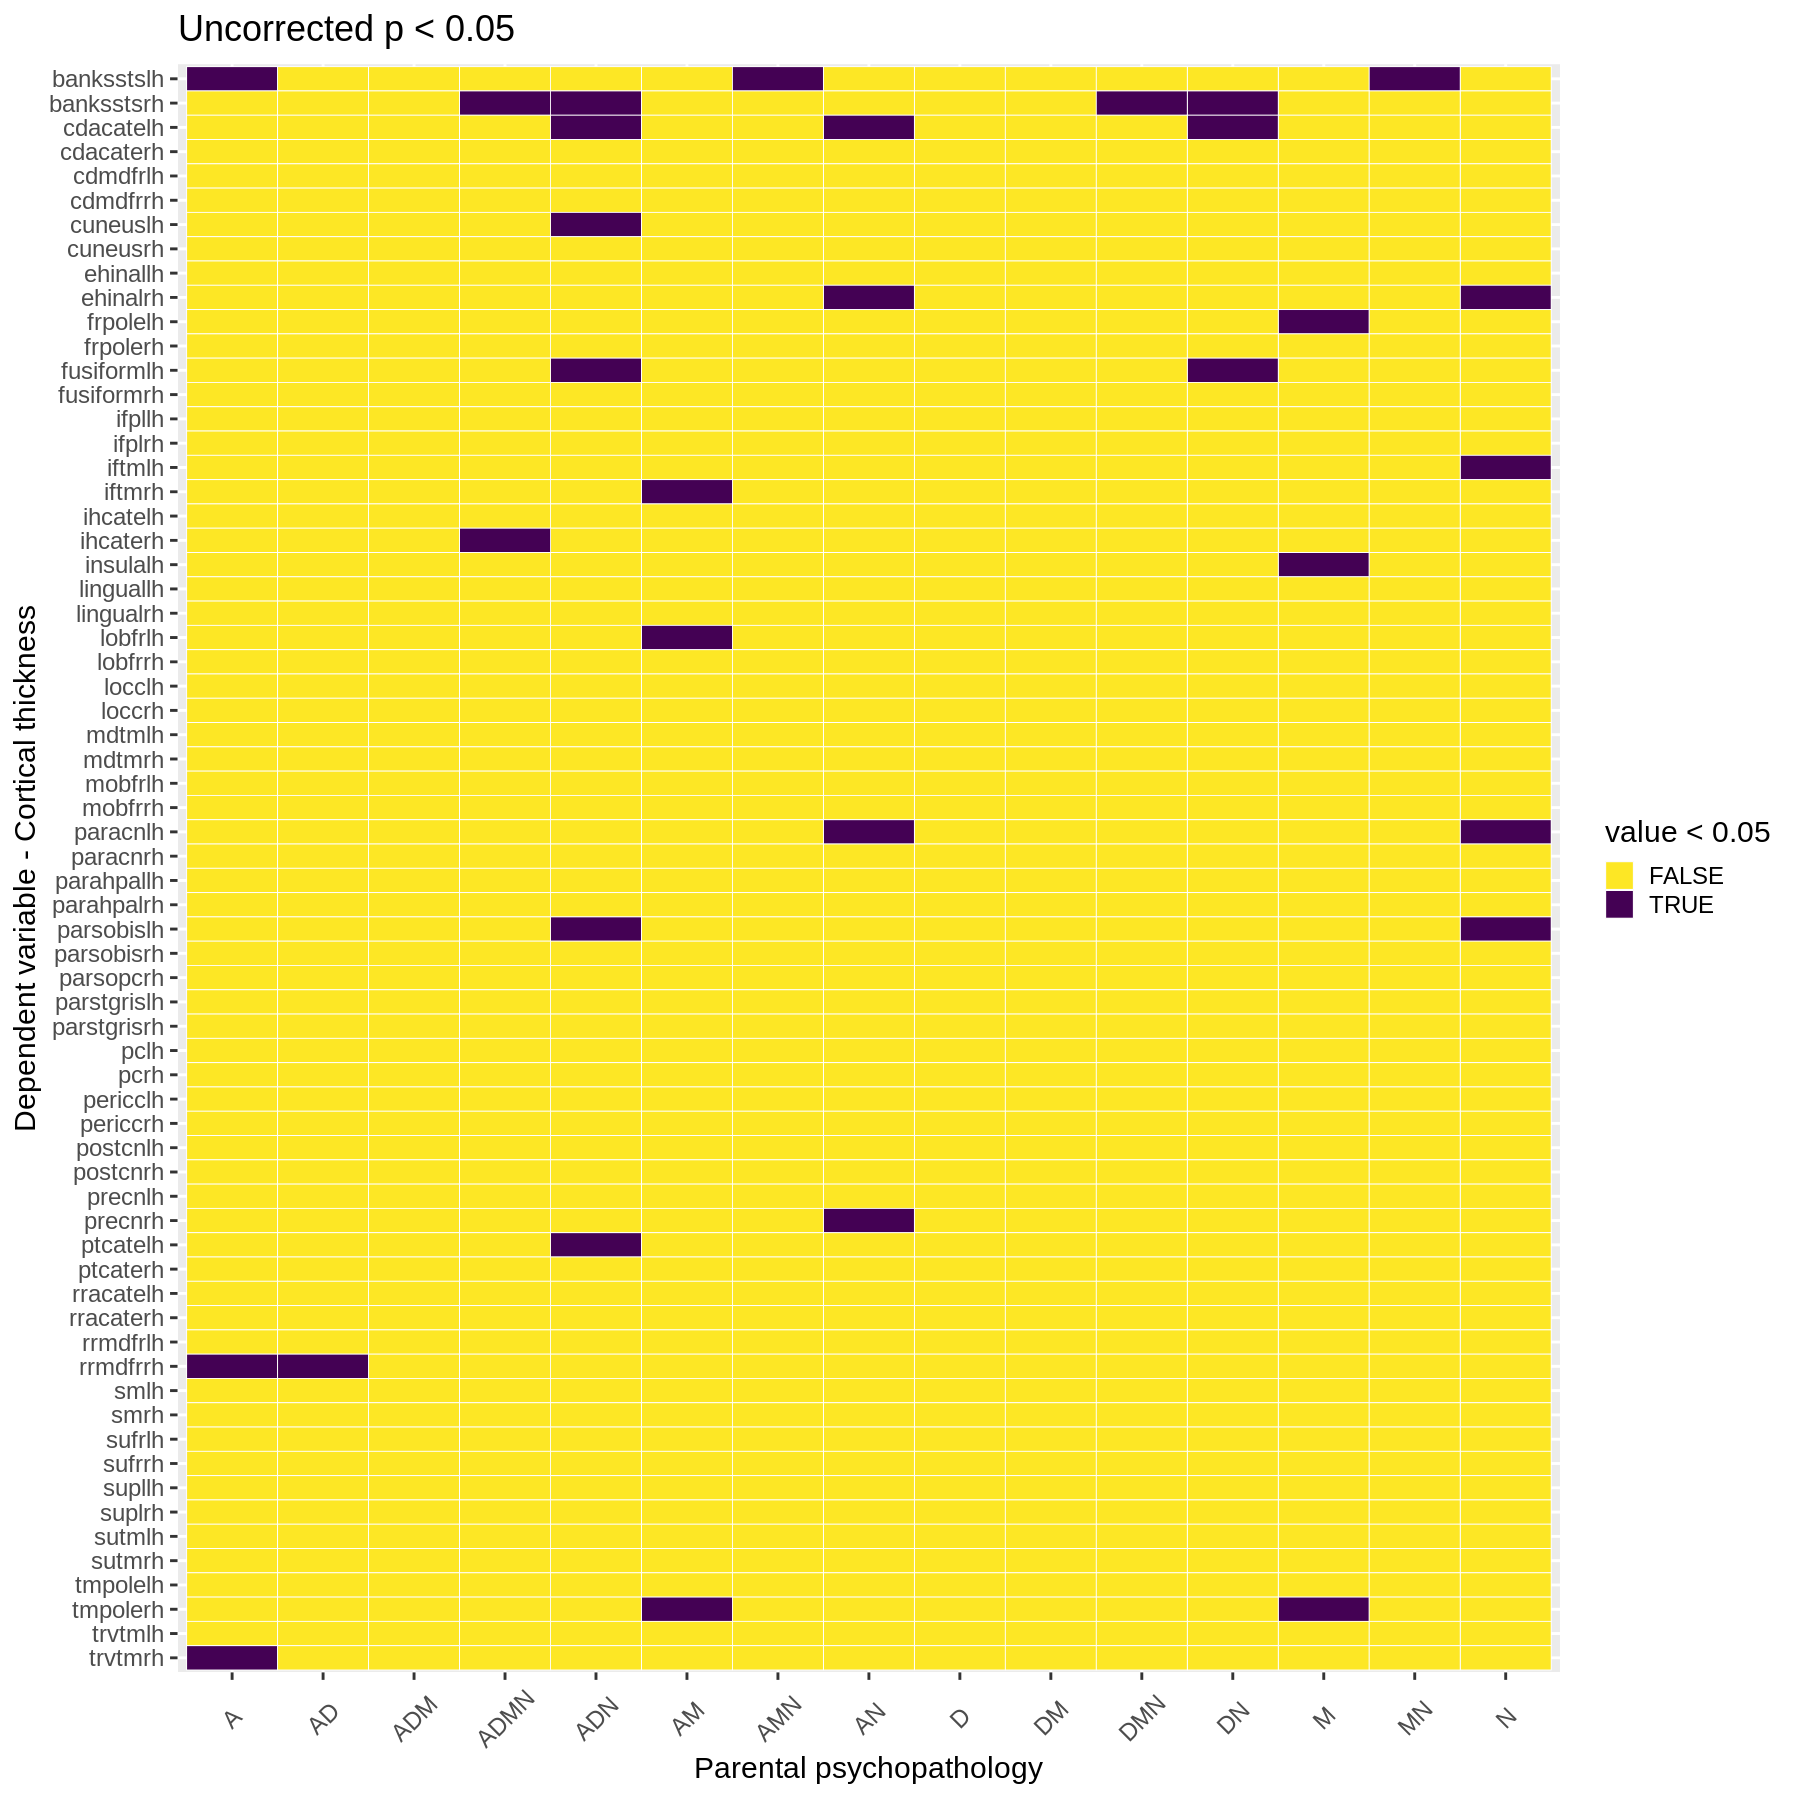

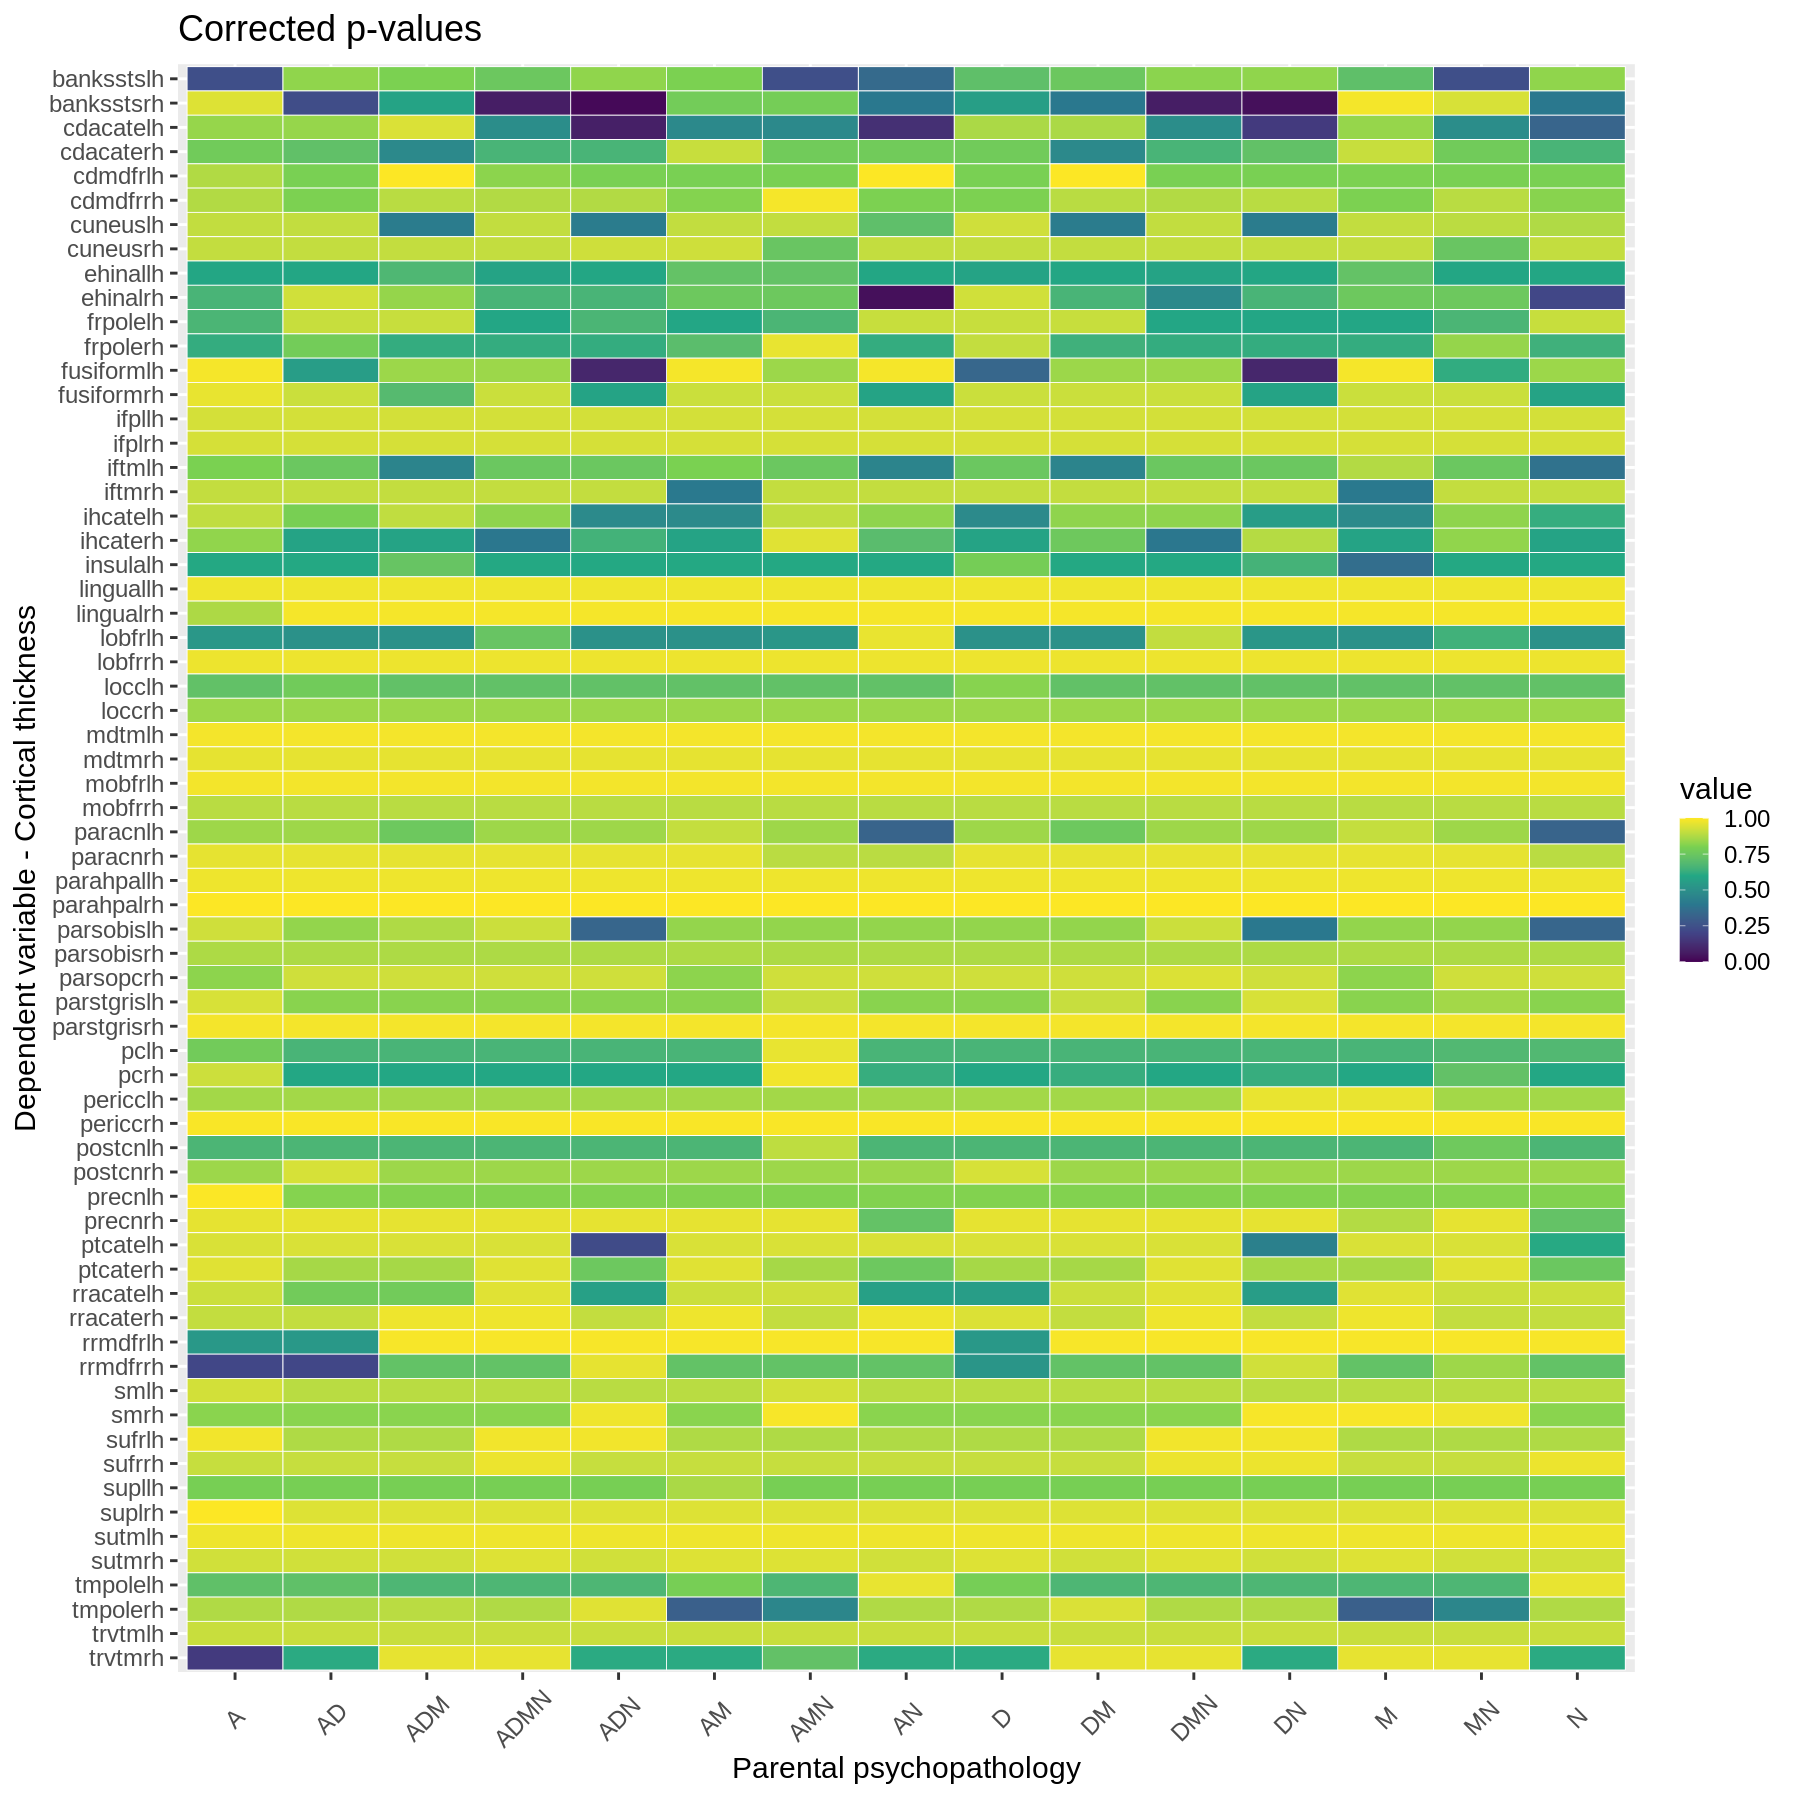

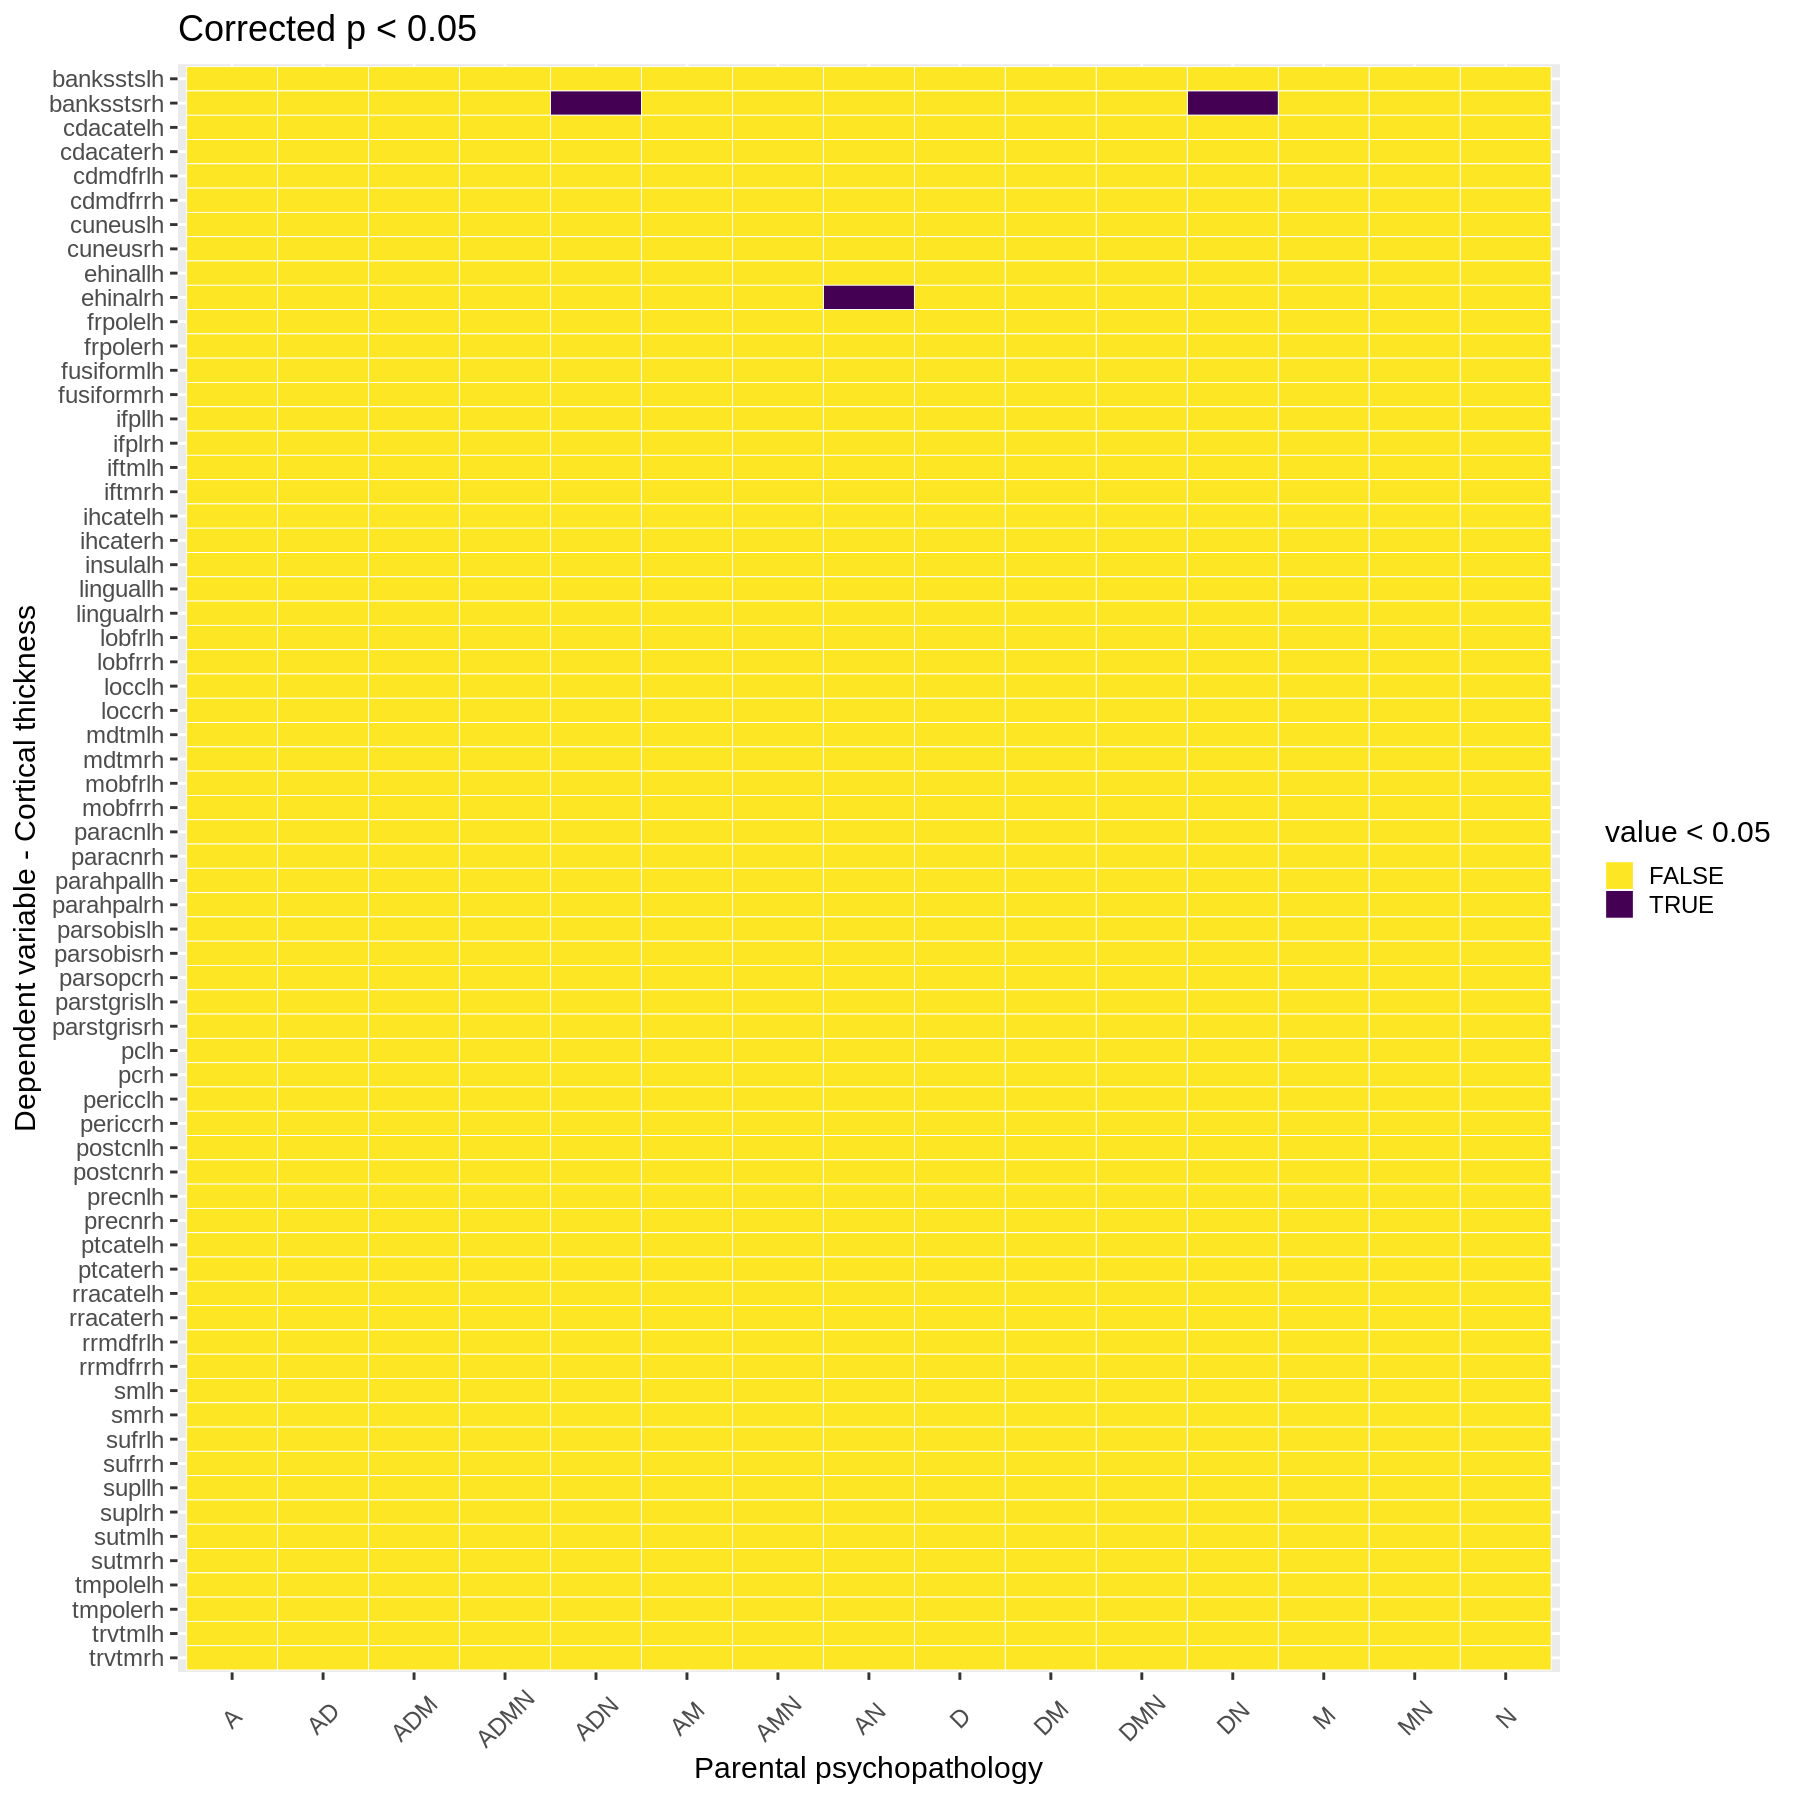

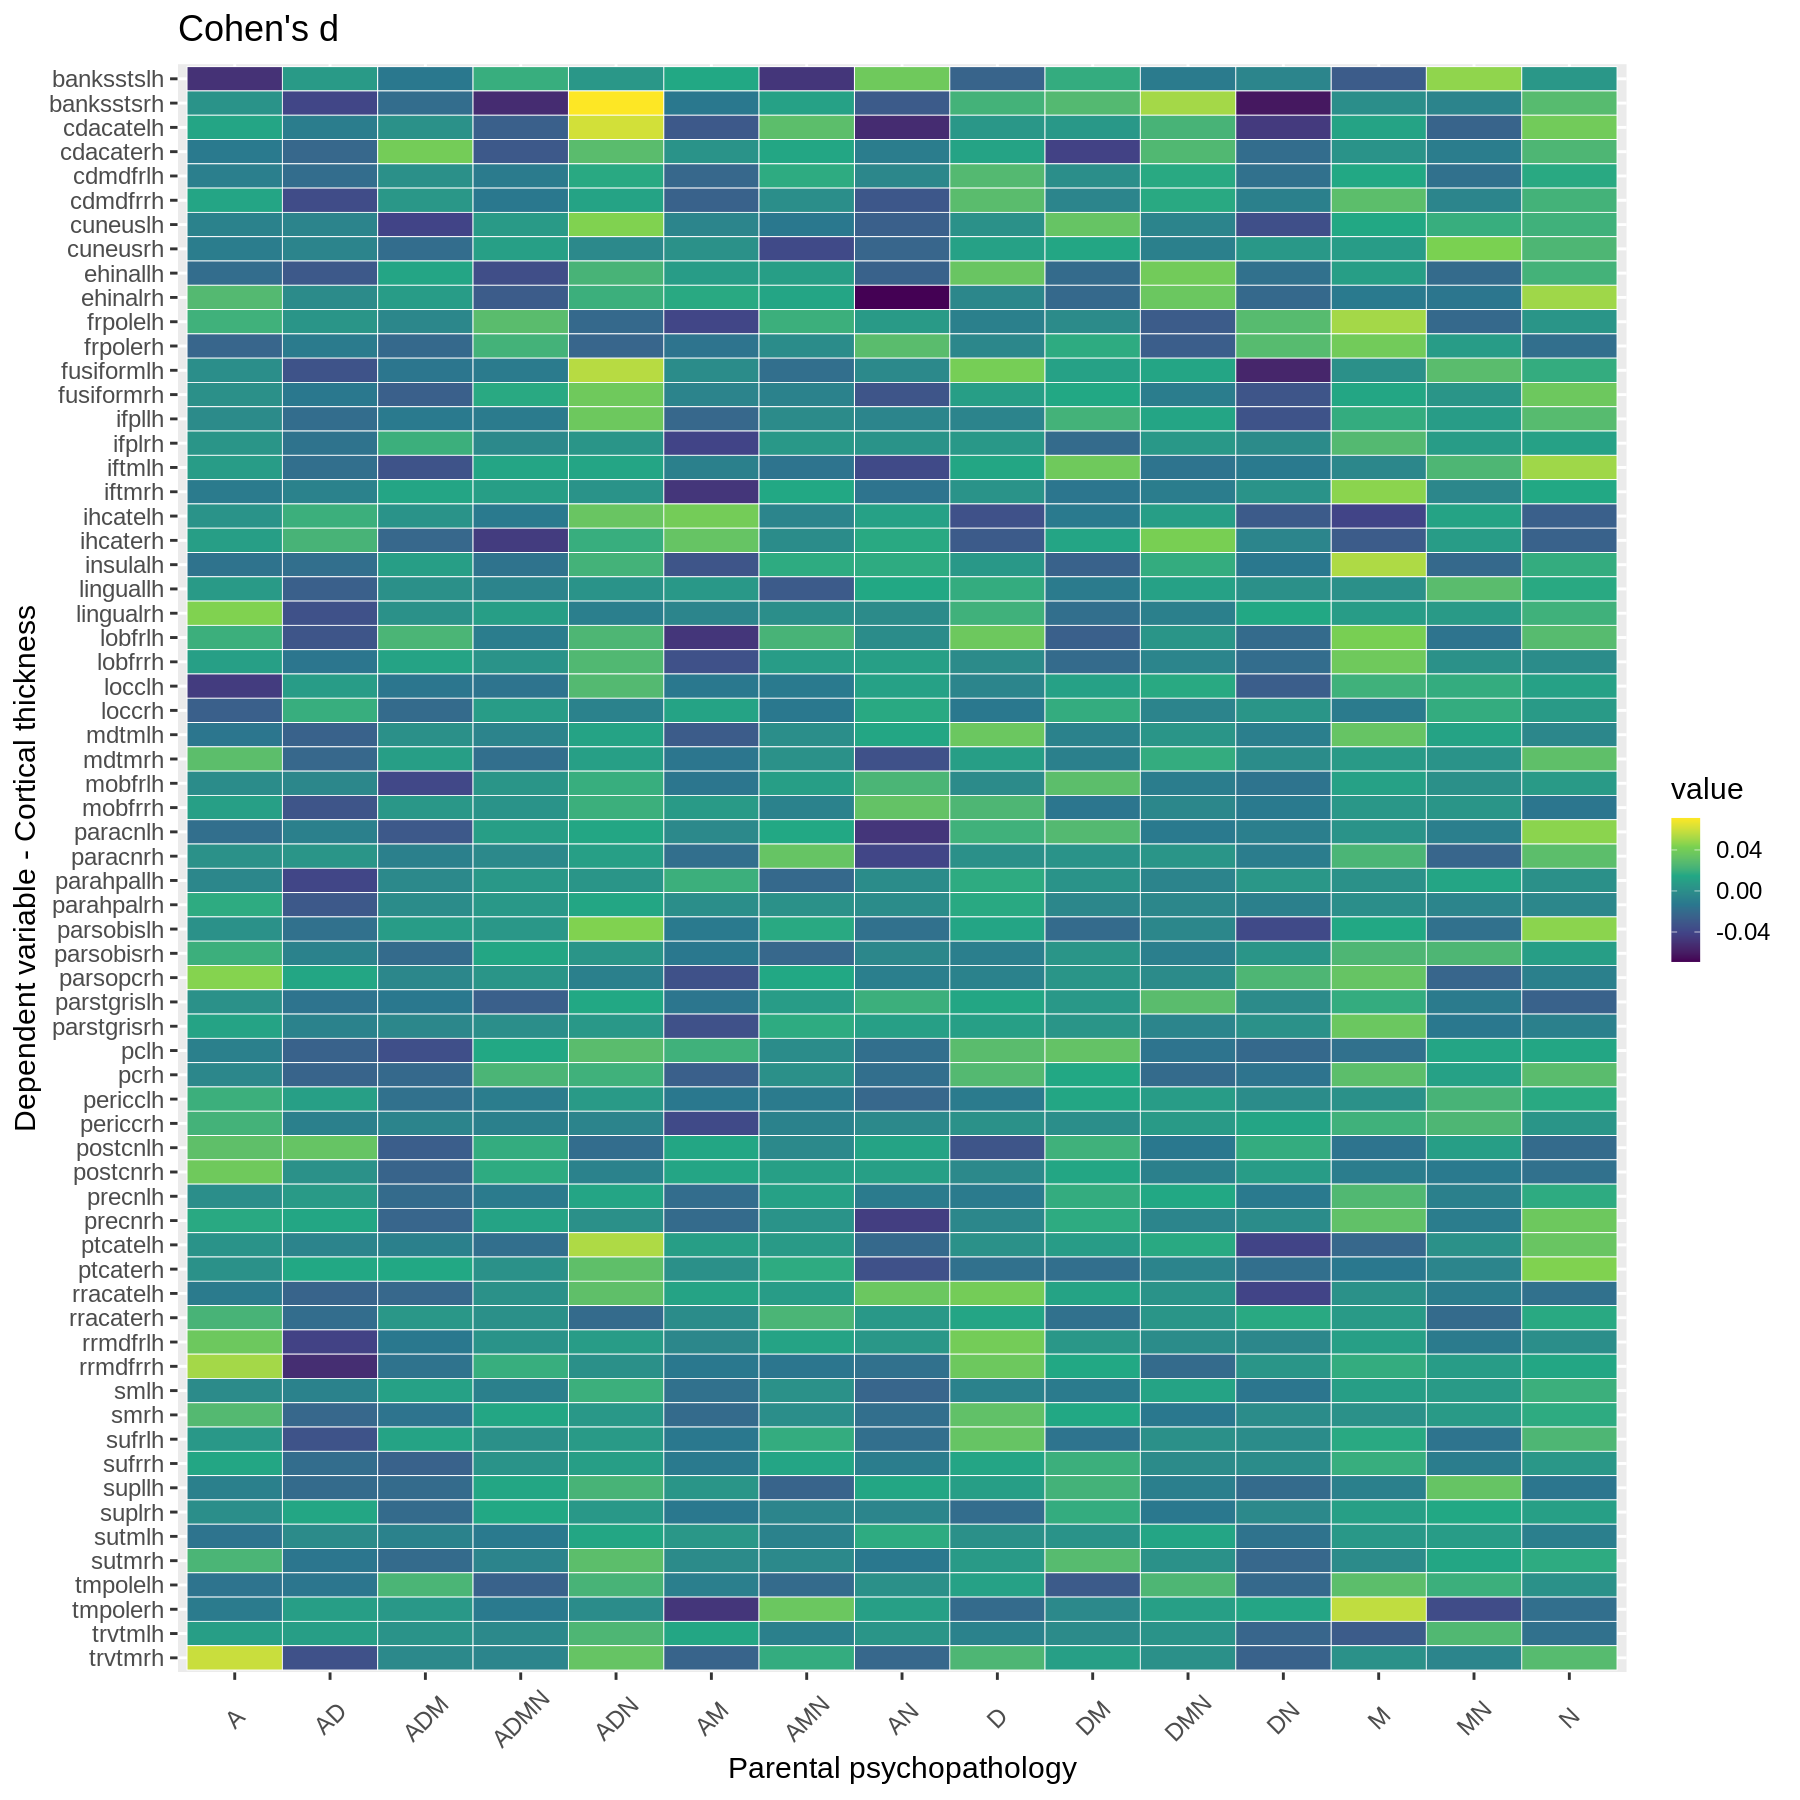

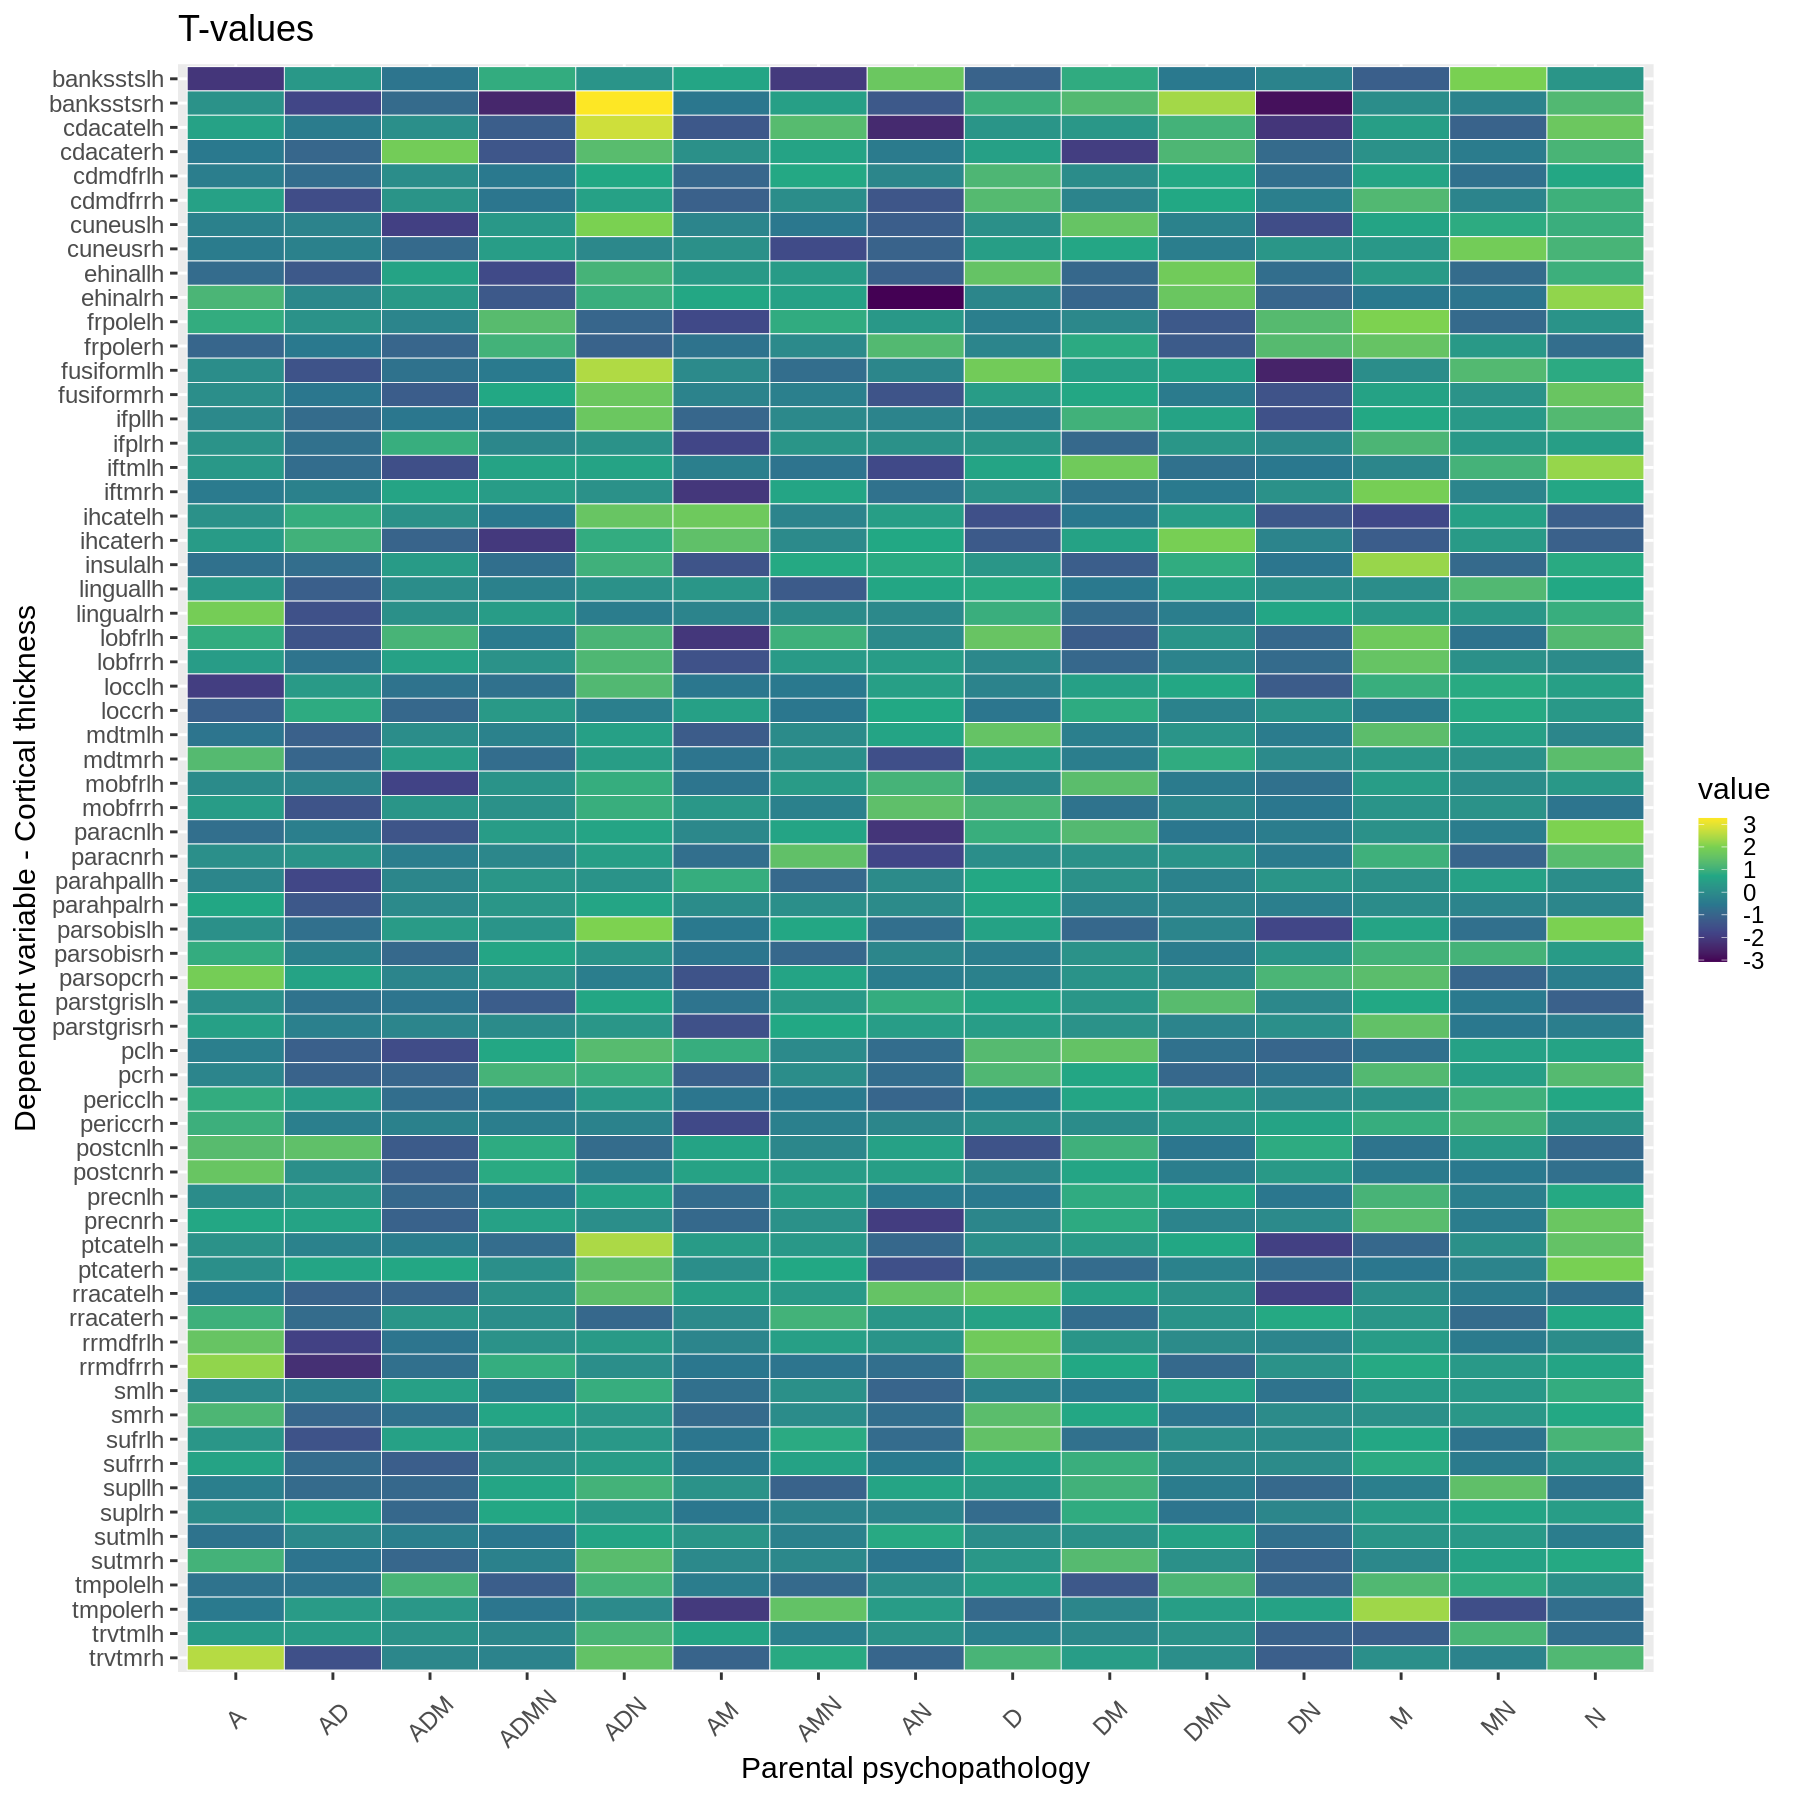

In [109]:
#Heatmaps
#Uncorrected P
options(repr.plot.width=15, repr.plot.height=15)
p1a <- ggplot(tabp3_long, aes(x = rowname, y = colname, fill = value)) +
geom_tile(colour="white",size=0.25)+
scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Cortical thickness", x = "Parental psychopathology", title = "Uncorrected p-values") +
theme_grey(base_size=18) +
theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p1a)

# logicals p < .05 - ONLY interesting if P-values were inserted in code above. 
p2a <- ggplot(tabp3_long, aes(x = rowname, y = colname, fill = value < .05)) +
geom_tile(colour="white",size=0.25) +
scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Cortical thickness", x = "Parental psychopathology", title = "Uncorrected p < 0.05") +
theme_grey(base_size=18) +
theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p2a)

#Corrected P
p1b <- ggplot(tabp3cor_long, aes(x = rowname, y = colname, fill = value)) +
geom_tile(colour="white",size=0.25)+
scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Cortical thickness", x = "Parental psychopathology", title = "Corrected p-values") +
theme_grey(base_size=18) +
theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p1b)

# logicals p < .05 - ONLY interesting if P-values were inserted in code above. 
p2b <- ggplot(tabp3cor_long, aes(x = rowname, y = colname, fill = value < .05)) +
geom_tile(colour="white",size=0.25) +
scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Cortical thickness", x = "Parental psychopathology", title = "Corrected p < 0.05") +
theme_grey(base_size=18) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p2b)

#heatmap cohen's d
p3 <- ggplot(tabd3_long, aes(x = rowname, y = colname, fill = value)) +
geom_tile(colour="white",size=0.25)+
scale_fill_viridis_c()  +
labs(y="Dependent variable - Cortical thickness", x = "Parental psychopathology", title = "Cohen's d") +
theme_grey(base_size=18) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p3)

p4 <- ggplot(tabt3_long, aes(x = rowname, y = colname, fill = value)) +
geom_tile(colour="white",size=0.25)+
scale_fill_viridis_c()  +
labs(y="Dependent variable - Cortical thickness", x = "Parental psychopathology", title = "T-values")+
theme_grey(base_size=18) +
theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p4)

[1] 32

In [ ]:
# plot effects
set_theme(
    base = theme_bw(),
)

# Three-way interaction in left and right caudate
#left caudate
p1_pred <- plot_model(m[[10]], type="pred", terms = c("Nervousness", "Addiction")) #plot interaction
p2_pred <- plot_model(m[[2]], type="pred", terms = c("Depression", "Nervousness", "Addiction")) #plot interaction




In [103]:
dependentVar


[1] "win_smri_thick_cdk_banksstslh.z"  "win_smri_thick_cdk_banksstsrh.z" 
 [3] "win_smri_thick_cdk_cdacatelh.z"   "win_smri_thick_cdk_cdacaterh.z"  
 [5] "win_smri_thick_cdk_cdmdfrlh.z"    "win_smri_thick_cdk_cdmdfrrh.z"   
 [7] "win_smri_thick_cdk_cuneuslh.z"    "win_smri_thick_cdk_cuneusrh.z"   
 [9] "win_smri_thick_cdk_ehinallh.z"    "win_smri_thick_cdk_ehinalrh.z"   
[11] "win_smri_thick_cdk_frpolelh.z"    "win_smri_thick_cdk_frpolerh.z"   
[13] "win_smri_thick_cdk_fusiformlh.z"  "win_smri_thick_cdk_fusiformrh.z" 
[15] "win_smri_thick_cdk_ifpllh.z"      "win_smri_thick_cdk_ifplrh.z"     
[17] "win_smri_thick_cdk_iftmlh.z"      "win_smri_thick_cdk_iftmrh.z"     
[19] "win_smri_thick_cdk_ihcatelh.z"    "win_smri_thick_cdk_ihcaterh.z"   
[21] "win_smri_thick_cdk_insulalh.z"    "win_smri_thick_cdk_linguallh.z"  
[23] "win_smri_thick_cdk_lingualrh.z"   "win_smri_thick_cdk_lobfrlh.z"    
[25] "win_smri_thick_cdk_lobfrrh.z"     "win_smri_thick_cdk_locclh.z"     
[27] "win_smri_thick_cdk_loccrh.z"      "win_smri_thick_cdk_mdtmlh.z"     
[29] "win_smri_thick_cdk_mdtmrh.z"      "win_smri_thick_cdk_mobfrlh.z"    
[31] "win_smri_thick_cdk_mobfrrh.z"     "win_smri_thick_cdk_paracnlh.z"   
[33] "win_smri_thick_cdk_paracnrh.z"    "win_smri_thick_cdk_parahpallh.z" 
[35] "win_smri_thick_cdk_parahpalrh.z"  "win_smri_thick_cdk_parsobislh.z" 
[37] "win_smri_thick_cdk_parsobisrh.z"  "win_smri_thick_cdk_parsopcrh.z"  
[39] "win_smri_thick_cdk_parstgrislh.z" "win_smri_thick_cdk_parstgrisrh.z"
[41] "win_smri_thick_cdk_pclh.z"        "win_smri_thick_cdk_pcrh.z"       
[43] "win_smri_thick_cdk_pericclh.z"    "win_smri_thick_cdk_periccrh.z"   
[45] "win_smri_thick_cdk_postcnlh.z"    "win_smri_thick_cdk_postcnrh.z"   
[47] "win_smri_thick_cdk_precnlh.z"     "win_smri_thick_cdk_precnrh.z"    
[49] "win_smri_thick_cdk_ptcatelh.z"    "win_smri_thick_cdk_ptcaterh.z"   
[51] "win_smri_thick_cdk_rracatelh.z"   "win_smri_thick_cdk_rracaterh.z"  
[53] "win_smri_thick_cdk_rrmdfrlh.z"    "win_smri_thick_cdk_rrmdfrrh.z"   
[55] "win_smri_thick_cdk_smlh.z"        "win_smri_thick_cdk_smrh.z"       
[57] "win_smri_thick_cdk_sufrlh.z"      "win_smri_thick_cdk_sufrrh.z"     
[59] "win_smri_thick_cdk_supllh.z"      "win_smri_thick_cdk_suplrh.z"     
[61] "win_smri_thick_cdk_sutmlh.z"      "win_smri_thick_cdk_sutmrh.z"     
[63] "win_smri_thick_cdk_tmpolelh.z"    "win_smri_thick_cdk_tmpolerh.z"   
[65] "win_smri_thick_cdk_trvtmlh.z"     "win_smri_thick_cdk_trvtmrh.z"

In [ ]:
ptab[[2]]